 COMPARACIÓN DEL Nº DE COPIA NORMALIZADO (NCN)
=====

Frente a la pregunta ¿dónde hay mayor nº de copias de ARG/MGE? el poder responder ha sido siempre controvertido, puesto que el hecho de que haya infinidad de 0s dificulta muchísimo el tomar todos los datos en conjunto a la par que la contra, el centrarse sólo en los genes que han amplificado, dificulta mucho el poder responder a la pregunta y quita muchísimas réplicas, tanto que empieza a haber problemas de poder estadístico.

Sin embargo, creo que la solución pasa por asumir esas dos circunstancias y hacerlas parte de nuestra respuesta: ¿dónde hay mayor nº de copias de ARG/MGE? Depende: a nivel general, en los plásticos por su mayor diversidad, pero a nivel de genes/familias compartidas, la respuesta depende del ambiente, aunque hay casos en los que nos falta poder estadístico para poder responder con seguridad

Dicho eso, al meollo.

Se me ocurre responder de dos maneras a la pregunta.

- Ver cuáles son los ARG comunes, computar la suma de NCN para ellos en cada muestra, dividirlo por el nº de secuencias comunes para ese caso y comparar
- Por si hiciera falta, también se puede respaldar con la misma pregunta pero usando todas las secuencias. Eso respondería en general.

Ojo, voy a separar desde el principio ARGs y MGEs. No me interesa comparar entre ellos en ningún caso y tenerlos juntos supone mezclar dos datasets que pueden meter mucho ruido sin causa justificada.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
import scikit_posthocs as sp
import matplotlib
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Current wd: the script directory
os.chdir("../data/clean_data") #data directory
data_dir = os.getcwd()
os.chdir("../../results/NCN_res") # general results dir for these analysis
os.chdir("all") # the subdirectory for when all data is considered
all_dir = os.getcwd()
os.chdir("../common") # subdirectory for when only common seqs are considered
common_dir = os.getcwd()
os.chdir("../common-adjusted") #as the dir name implies
ca_dir = os.getcwd()
print(os.getcwd())

/home/pak/Desktop/ARG-L/resistome/results/NCN_res/common-adjusted


In [23]:
os.chdir(data_dir)
all_data = pd.read_csv("ab_data_all_fixed.csv", index_col = 0)
all_data.fillna(0, inplace = True)
all_data = all_data[(all_data["antib"] != "16S")]
all_data = all_data[["Assay", "antib", "sample", "place", "type_f", "type_g", "or_seq", "rel_ab"]] #place viene a ser la estrella del show
all_data = all_data.loc[~all_data["place"].isin([0])]
all_data.loc[all_data["sample"] == 13, "rel_ab"] = all_data.loc[all_data["sample"] == 13]["rel_ab"] / 3
all_data.loc[all_data["sample"] == 14, "rel_ab"] = all_data.loc[all_data["sample"] == 14]["rel_ab"] / 3
all_data = all_data[(all_data.Assay != "aadA7") & (all_data.sample != 5)] #esto también es tremendamente importante
all_data.head()

,Assay,antib,sample,place,type_f,type_g,or_seq,rel_ab
0,aacC2,Aminoglycoside,25.0,ardley,PUR,plastic,arg,0.000222
1,aacA/aphD,Aminoglycoside,25.0,ardley,PUR,plastic,arg,0.000046
2,aac(6')-II,Aminoglycoside,25.0,ardley,PUR,plastic,arg,0.006918
3,aphA3,Aminoglycoside,25.0,ardley,PUR,plastic,arg,0.000000
4,sat4,Aminoglycoside,25.0,ardley,PUR,plastic,arg,0.000000


There's a last fix that needs to be made to the dataset: group both lakes as a general "lake" variable. I won't be able to do statistics on Ionosférico data due to the low number of replicates, so separating by sampling place is not an option. However, separating by sampling ambient (lacustrine vs inland) is. Also, I won't be dropping the original place column, as that variable is still needed to filter for common amps

In [24]:
all_data.loc[all_data["place"] == "ardley", "ambient"] = "ard"
all_data.loc[all_data["place"] != "ardley", "ambient"] = "lake"
all_data.tail()

,Assay,antib,sample,place,type_f,type_g,or_seq,rel_ab,ambient
10309,dfrAB4,Trimethoprim,14.0,ion,water,control,arg,0.0,lake
10310,dfrC,Trimethoprim,14.0,ion,water,control,arg,0.0,lake
10311,dfrG,Trimethoprim,14.0,ion,water,control,arg,0.0,lake
10312,dfrK,Trimethoprim,14.0,ion,water,control,arg,0.0,lake
10313,dfrBmulti,Trimethoprim,14.0,ion,water,control,arg,0.0,lake


## COMPARATIVA DEL Nº DE COPIA A NIVEL GENERAL

Aquí busco responder a la pregunta más inmediata: ¿hay más copias de ARG/MGE en plásticos o en controles?

### COMPARATIVA SIN DIFERENCIAR POR PUNTO DE MUESTREO

In [25]:
os.chdir(all_dir)
general_grouped = all_data.groupby(["sample", "or_seq","type_g"]) #agrupa los datos según tipología. LO importante, también por nº de muestra
summed_samples = general_grouped["rel_ab"].sum() # y calcula la suma del nº de copias de todos los integrantes
summed_samples = summed_samples.reset_index() #aquí paso a df para facilitar el resto de pasos
summed_samples.loc[summed_samples["sample"] < 12].head()

,sample,or_seq,type_g,rel_ab
0,1.0,arg,control,0.006522
1,1.0,mge,control,0.006081
2,2.0,arg,control,0.000533
3,2.0,mge,control,0.001262
4,3.0,arg,control,0.000747


In [26]:
# Meto un logaritmo para poder comparar resultados con uno y otro
summed_samples["n_log2"] = np.log2(summed_samples["rel_ab"])

Aunque aquí suceda en menor medida, tenemos un problema recurrente sobre el tipo de test a emplear. Por un lado, un test de muestras independientes (t-test, mannwhitney) responde inmediatamente a nuestra pregunta de si plásticos o control tienen más, por otro está el hecho a considerar de que no sólo existen los pásticos y los controles, sino que siempre serán ARGs y MGEs, asi que quizás debiéramos tener comparaciones múltiples. Por curarme de espanto, empleo ambas aproximaciones en todo momento.

In [27]:
def statistic_mean(x, y, axis):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)

In [8]:
def get_difs(groupby_data, var = "rel_ab", detailed = False, alternative = "two-sided", significant = True, grouping_var = "type_g"):
    """
    A highly hardcoded function that I'm defining only because it will make the rest of the notebook cleaner. Designed to take a multi-indexed groupby object
    and perform some basic analysys on it: normality, homocedasticity and the corresponding test of means' difference. It probably incurs in Type I error, as it compares multiples
    pairs of control-sample samples (they are NOT paired samples, mind you)
    
    - groupby_data: the groupby object that contains the data to analyze. As it is programmed, it MUST contain a column with a descriptive, binary value: control and study samples
    - var: name of the column whose values we want to compare
    - detailed: change it to True to get a detailed printing of all the tests being conducted
    - alternative: which altenative hypothesis to feed to the paired tests. I0m running scipy tests, so it works with the same values (less, two-sided, greater)
    - significant: if True, keep just those with pval < 0.05; if False, keep everything
    """
    result_dict = {}
    for name, group in groupby_data:
        name = str(name).upper()
        pl_data = group.loc[group[grouping_var] == "plastic"][var]
        con_data = group.loc[group[grouping_var] == "control"][var]
        
        # Tests de normalidad
        norm_plas = stats.shapiro(pl_data)
        norm_con = stats.shapiro(con_data)
        
        # Tests de homocedasticidad
        if (norm_plas[1] > 0.05) and (norm_con[1] > 0.05):
            norm = True
            homo = stats.bartlett(pl_data, con_data)
        else: 
            norm = False
            homo = stats.levene(pl_data, con_data)
            
        # Test de igualdad de distribuciones
        if (homo[1] > 0.05) and (norm == True): 
            result = stats.ttest_ind(a = pl_data, b = con_data, alternative = alternative)
        elif (homo[1] > 0.05): #homocedásticos no normales
            result = stats.mannwhitneyu(x = pl_data, y = con_data, alternative = alternative)
        elif (homo[1] < 0.05) and (norm == True): #normales no homocedásticos
            result = stats.ttest_ind(a = pl_data, b = con_data, alternative = alternative, equal_var = False)
            result = ("Welch!", result[1], result[0])
        else: #todo mal, permuta
            result = stats.permutation_test(data = (pl_data, con_data), statistic =  statistic_mean, 
                                            vectorized = True, n_resamples = 20000,
                                            alternative = alternative, permutation_type = "independent")
            result = ("Permutation", result.pvalue, result.statistic) #ugly hack!
        if significant == True:
            if result[1] < 0.05: result_dict[name] = result
        else: 
            result_dict[name] = result
            
            
            
        if detailed == True:
            print("##########", name, "#########")
            print("### PLASTIC ###")
            print(norm_plas)
            print("### CONTROL ###")
            print(norm_con)
            print("### BOTH ###")
            print(homo)
            print("### DIFFERENCES ###")
            print(result)
            print("")
    return result_dict

In [28]:
general_difs = get_difs(summed_samples.groupby("or_seq"), var = "rel_ab", 
                        detailed = False, alternative = "two-sided", significant = True)
general_log_difs = get_difs(summed_samples.groupby("or_seq"), var = "n_log2", 
                        detailed = False, alternative = "two-sided", significant = True)

with open("pair_statistics.txt", "w") as file:
    print("Significant, NCN results: ", general_difs, file = file)
    print("Significant, log2 NCN results: ", general_log_difs, file = file)

In [10]:
arg_general_sums = summed_samples.loc[summed_samples["or_seq"] == "arg"]
mge_general_sums = summed_samples.loc[summed_samples["or_seq"] == "mge"]

In [11]:
# Empiezo con algo tontorrón: los colores a usar
BG_WHITE = "#fbf9f4"
GREY_LIGHT = "#b4aea9"
GREY50 = "#7F7F7F"
BLUE_DARK = "#1B2838"
BLUE = "#2a475e"
BLACK = "#282724"
GREY_DARK = "#747473"
RED_DARK = "#850e00"

In [12]:
# Ahora posiciones de elementos decorativos
means_arg = [value for name, value in arg_general_sums.groupby("type_g")["rel_ab"].mean().items()] #esto es el valor de las medias pero lo usaré de posición
means_arg_log = [value for name, value in arg_general_sums.groupby("type_g")["n_log2"].mean().items()]
names = [name for name, value in summed_samples.groupby("type_g")["rel_ab"].mean().items()]
means_mge = [value for name, value in mge_general_sums.groupby("type_g")["rel_ab"].mean().items()]
means_mge_log = [value for name, value in mge_general_sums.groupby("type_g")["n_log2"].mean().items()]
#print(list(zip(means, names)))
#necesario darle la vuelta 
#means.reverse()

In [13]:
def make_chuli_plot_violin(data, x, y, mean_list, line_list, title, figsize, orient = "horizontal"):
    # Ya la figura ------------------------------------------
    fig, ax = plt.subplots(figsize = figsize)

    #Color de fondo
    fig.patch.set_facecolor(BG_WHITE)
    ax.set_facecolor(BG_WHITE)

    # Líneas horizontales de escala
    for hline in line_list:
        if orient == "horizontal":
            ax.axvline(hline, color = GREY50, ls = (0, (5, 5)), alpha = 0.8, zorder = 0)
        else:
            ax.axhline(hline, color = GREY50, ls = (0, (5, 5)), alpha = 0.8, zorder = 0)
    # Violines
    violins = sns.violinplot(data = data, x = x, y = y,
                            cut = 0.1, scale = "count", inner = None, legend = False,
                            bw = "silverman", linewidth = 1.5)

    # Cajas
    boxes = sns.boxplot(data = data, x = x, y = y,  
                        boxprops = {"zorder": 2, "facecolor": "none", "linewidth": 1.4},
                        whiskerprops = {"color": BLACK, "linewidth": 1.4},
                        medianprops = {"color": GREY_DARK, "solid_capstyle": "butt", "linewidth": 4},
                        showcaps = False
                       )
    #Stripplot
    points = sns.stripplot(data = data, x = x, y = y, 
                           s = 15, alpha = 0.9, linewidth = 1, legend = False, palette = "deep")

    # Customize violins (remove fill, customize line, etc.)
    for collection in ax.collections:
        if isinstance(collection, matplotlib.collections.PolyCollection):
            collection.set_edgecolor(BLACK)
            collection.set_facecolor('none')

    # Add mean value labels ------------------------------------------
    if orient == "horizontal":
        for mean, pos in zip(mean_list[:], ax.get_yticks()):
            # Add dot representing the mean
            ax.scatter(mean, pos, s=150, color=RED_DARK, zorder=3, edgecolors = BLACK)
            # Add line conecting mean value and its label
            ax.plot([mean, mean], [pos, pos + 0.3], ls="dashdot", color="black", zorder=3)
            # Add mean value label.
            ax.text(mean, pos +0.3,
                    r"$\hat{\mu}_{\rm{mean}} = $" + str(round(mean, 3)), fontsize=13, va="center",
                    bbox = {"facecolor":"white","edgecolor":BLACK, "boxstyle":"round", "pad":0.15},
                    zorder = 10
                   )
    else:
        for mean, pos in zip(mean_list[:], ax.get_xticks()):
            ax.scatter(pos, mean, s=150, color=RED_DARK, zorder=3, edgecolors = BLACK)
            ax.plot([pos, pos + 0.3], [mean, mean], ls="dashdot", color="black", zorder=3)
            ax.text(pos + 0.3, mean,
                    r"$\hat{\mu}_{\rm{mean}} = $" + str(round(mean, 3)), fontsize=13, va="center",
                    bbox = {"facecolor":"white","edgecolor": BLACK, "boxstyle":"round", "pad":0.15},
                    zorder = 10
                   )

    #plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax.set_title(title.upper())
    plt.legend([],[], frameon=False) #ugly hack!

In [14]:
def make_chuli_plot(data, x, y, mean_list, line_list, title, figsize, orient = "horizontal"):
    # Ya la figura ------------------------------------------
    fig, ax = plt.subplots(figsize = figsize)

    #Color de fondo
    fig.patch.set_facecolor(BG_WHITE)
    ax.set_facecolor(BG_WHITE)

    # Líneas horizontales de escala
    for hline in line_list:
        if orient == "horizontal":
            ax.axvline(hline, color = GREY50, ls = (0, (5, 5)), alpha = 0.8, zorder = 0)
        else:
            ax.axhline(hline, color = GREY50, ls = (0, (5, 5)), alpha = 0.8, zorder = 0)

    # Cajas
    boxes = sns.boxplot(data = data, x = x, y = y,  
                        boxprops = {"zorder": 2, "facecolor": "none", "linewidth": 1.4},
                        whiskerprops = {"color": BLACK, "linewidth": 1.4},
                        medianprops = {"color": GREY_DARK, "solid_capstyle": "butt", "linewidth": 4},
                        showcaps = False
                       )
    #Stripplot
    points = sns.stripplot(data = data, x = x, y = y, 
                           s = 15, alpha = 0.9, linewidth = 1, legend = False, palette = "deep")
    # Add mean value labels ------------------------------------------
    if orient == "horizontal":
        for mean, pos in zip(mean_list[:], ax.get_yticks()):
            # Add dot representing the mean
            ax.scatter(mean, pos, s=150, color=RED_DARK, zorder=3, edgecolors = BLACK)
            # Add line conecting mean value and its label
            ax.plot([mean, mean], [pos, pos + 0.3], ls="dashdot", color="black", zorder=3)
            # Add mean value label.
            ax.text(mean, pos +0.3,
                    r"$\hat{\mu}_{\rm{mean}} = $" + str(round(mean, 3)), fontsize=13, va="center",
                    bbox = {"facecolor":"white","edgecolor":BLACK, "boxstyle":"round", "pad":0.15},
                    zorder = 10
                   )
    else:
        for mean, pos in zip(mean_list[:], ax.get_xticks()):
            ax.scatter(pos, mean, s=150, color=RED_DARK, zorder=3, edgecolors = BLACK)
            ax.plot([pos, pos + 0.3], [mean, mean], ls="dashdot", color="black", zorder=3)
            ax.text(pos + 0.3, mean,
                    r"$\hat{\mu}_{\rm{mean}} = $" + str(round(mean, 3)), fontsize=13, va="center",
                    bbox = {"facecolor":"white","edgecolor": BLACK, "boxstyle":"round", "pad":0.15},
                    zorder = 10
                   )

    #plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax.set_title(title.upper())
    plt.legend([],[], frameon=False) #ugly hack!

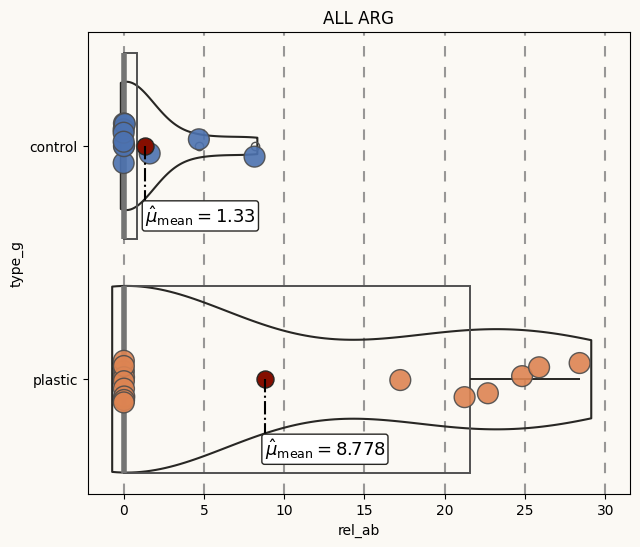

In [15]:
hlines = [0, 5, 10, 15, 20, 25, 30] #sacadas de observar el gráfico-borrador y ver en torno a qué valores van a estar nuestros datos
make_chuli_plot_violin(data = arg_general_sums, 
                       x = "rel_ab",
                       y = "type_g",
                       mean_list = means_arg, line_list = hlines,
                       title = "ALL ARG",
                       figsize = (7, 6),
                       )
plt.savefig("All ARG.png", bbox_inches= "tight")

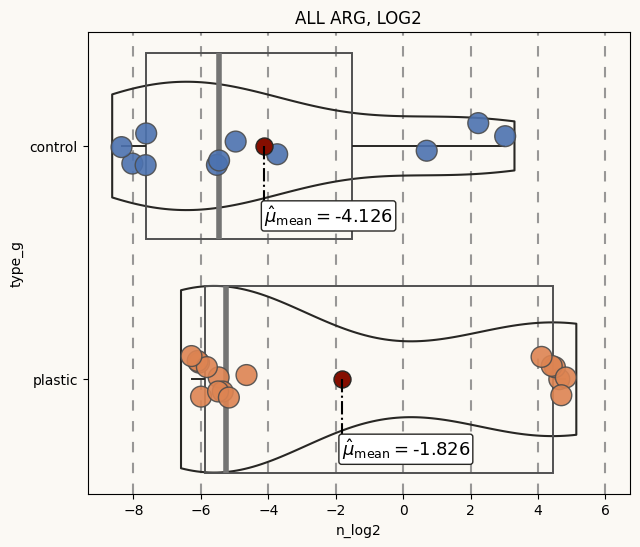

In [16]:
hlines_log = [-8, -6, -4, -2, 0, 2, 4, 6]
make_chuli_plot_violin(data = arg_general_sums, 
                       x = "n_log2",
                       y = "type_g",
                       mean_list = means_arg_log, line_list = hlines_log,
                       title = "ALL ARG, LOG2",
                       figsize = (7, 6),
                       )
plt.savefig("All ARG-log2.png", bbox_inches= "tight")

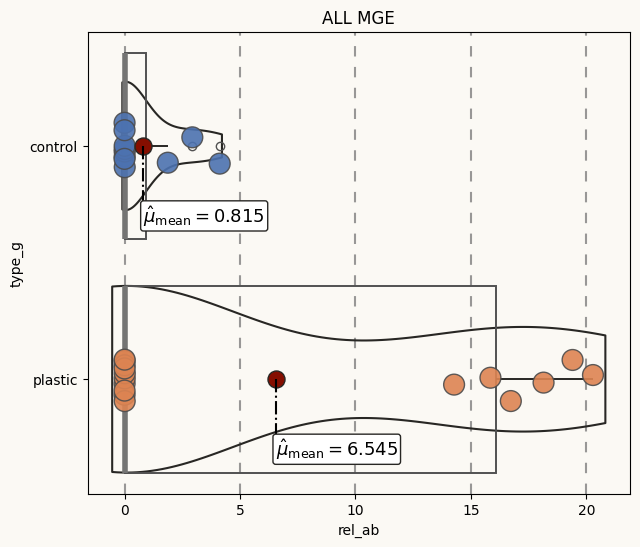

In [17]:
hlines = [0, 5, 10, 15, 20]
make_chuli_plot_violin(data = mge_general_sums, x = "rel_ab", y = "type_g", mean_list = means_mge, line_list = hlines, title = "ALL MGE", figsize = (7, 6))
plt.savefig("All MGE.png", bbox_inches= "tight")

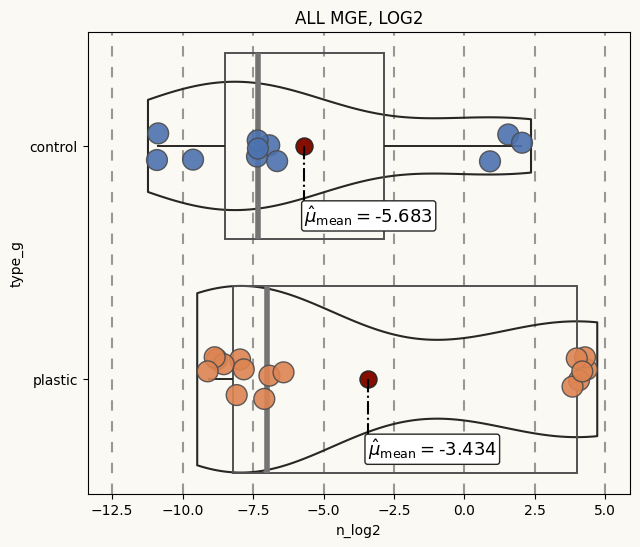

In [18]:
hlines_log = [-12.5, -10, -7.5, -5, -2.5, 0, 2.5, 5]
make_chuli_plot_violin(data = mge_general_sums, x = "n_log2", y = "type_g", mean_list = means_mge_log, line_list = hlines_log, title = "ALL MGE, LOG2", figsize = (7, 6))
plt.savefig("All MGE-log2.png", bbox_inches= "tight")

Aquí se empieza a intuir el porqué o bien no hay diferencia, o bien los controles son mayores: porque mientras que los plásticos están todos relativamente bien agrupados en torno al mismo (o, más a detalle, a los tres mismos valores), los controles NO, pudiendo diferenciarse claramente los tres puntos de muestreo entre ellos. Véase, **necesario dividir por punto de muestreo para poder realmente llegar a observar las diferencias**-

### COMPARATIVA DEL Nº DE COPIA DIFERENCIANDO POR PUNTO DE MUESTREO

In [43]:
all_data["hacky"] = all_data["ambient"] + "-" + all_data["type_f"] 
sp_grouped = all_data.groupby(["sample", "or_seq", "hacky"]) #agrupa los datos según tipología. LO importante, también por nº de muestra
summed_samples = sp_grouped["rel_ab"].sum() # y calcula la suma del nº de copias de todos los integrantes
summed_samples = summed_samples.reset_index() #aquí paso a df para facilitar el resto de pasos
summed_samples["n_log2"] = np.log2(summed_samples["rel_ab"])
summed_samples.loc[summed_samples["sample"] == 21]

,sample,or_seq,hacky,rel_ab,n_log2
40,21.0,arg,ard-soil,1.623156,0.698802
41,21.0,mge,ard-soil,1.873622,0.905830


In [44]:
for seq in summed_samples["or_seq"].unique():
    print("Working on ", seq.upper())
    seq_samples = summed_samples.loc[summed_samples["or_seq"] == seq]
    var_lst = [group["rel_ab"] for name, group in seq_samples.groupby(["hacky"])] #contains every group
    nam_lst = [name for name, group in seq_samples.groupby(["hacky"])] #contains the name of everygroup, SAME ORDER
    print("Regular values: ", stats.levene(*var_lst))
    var_lst_ln = [group["n_log2"] for name, group in seq_samples.groupby(["hacky"])]
    print("Log2: ", stats.levene(*var_lst_ln))
    fname = ambient.upper() + "-" + grouping.upper() +  "-arg_group_statistics.txt"
    with open(fname, "w") as file:
        print("Regular_values: ", stats.levene(*var_lst), file = file)
        print("Regular_kruskal: ", stats.kruskal(*var_lst), file = file)
        print("Log2_values: ", stats.levene(*var_lst_ln), file = file)
        print("Log2_kruskal: ", stats.kruskal(*var_lst_ln), file = file)
    print(stats.kruskal(*var_lst))
    post_lolo = sp.posthoc_conover(var_lst, p_adjust = "fdr_bh")
    post_lolo.rename(columns = {original_num:new_name for (original_num, new_name) in zip(post_lolo.columns, nam_lst)},
                         index = {original_num:new_name for (original_num, new_name) in zip(post_lolo.index, nam_lst)},
                         inplace = True)
    fname = seq.upper() + "-fuck-f.csv"
    post_lolo.to_csv(fname)
    print(post_lolo)

Working on  ARG
Regular values:  LeveneResult(statistic=3.261606534072809, pvalue=0.021107630593162365)
Log2:  LeveneResult(statistic=3.5494161966986493, pvalue=0.014753481933245024)
KruskalResult(statistic=23.16190476190475, pvalue=0.0007440267094813274)
                 (ard-EPS,)    (ard-PUR,)  (ard-soil,)  (lake-EPS,)  \
(ard-EPS,)     1.000000e+00  7.207637e-01     0.129274     0.000136   
(ard-PUR,)     7.207637e-01  1.000000e+00     0.066594     0.000072   
(ard-soil,)    1.292738e-01  6.659421e-02     1.000000     0.008063   
(lake-EPS,)    1.361832e-04  7.179863e-05     0.008063     1.000000   
(lake-PUR,)    1.323879e-04  6.673133e-05     0.007168     0.916824   
(lake-soil,)   1.334178e-07  1.239611e-07     0.000001     0.000132   
(lake-water,)  1.461797e-06  1.025424e-06     0.000050     0.008063   

               (lake-PUR,)  (lake-soil,)  (lake-water,)  
(ard-EPS,)        0.000132  1.334178e-07       0.000001  
(ard-PUR,)        0.000067  1.239611e-07       0.000001  
(

In [29]:
sp_grouped = all_data.groupby(["sample", "or_seq", "ambient", "type_g", "type_f"]) #agrupa los datos según tipología. LO importante, también por nº de muestra
summed_samples = sp_grouped["rel_ab"].sum() # y calcula la suma del nº de copias de todos los integrantes
summed_samples = summed_samples.reset_index() #aquí paso a df para facilitar el resto de pasos
summed_samples["n_log2"] = np.log2(summed_samples["rel_ab"])
summed_samples.loc[summed_samples["sample"] == 21]

,sample,or_seq,ambient,type_g,type_f,rel_ab,n_log2
40,21.0,arg,ard,control,soil,1.623156,0.698802
41,21.0,mge,ard,control,soil,1.873622,0.905830


#### ARG

In [30]:
for grouping in ["type_g", "type_f"]:
    print("######## ", grouping.upper(), " ########")
    for ambient in summed_samples["ambient"].unique():
        print("Working on ", ambient.upper())
        ambient_samples = summed_samples.loc[summed_samples["ambient"] == ambient]
        var_lst = [group["rel_ab"] for name, group in ambient_samples.loc[ambient_samples["or_seq"] == "arg"].groupby([grouping])] #contains every group
        nam_lst = [name for name, group in ambient_samples.loc[ambient_samples["or_seq"] == "arg"].groupby([grouping])] #contains the name of everygroup, SAME ORDER
        print("Regular values: ", stats.levene(*var_lst))
        var_lst_ln = [group["n_log2"] for name, group in ambient_samples.loc[ambient_samples["or_seq"] == "arg"].groupby([grouping])]
        print("Log2: ", stats.levene(*var_lst_ln))
        fname = ambient.upper() + "-" + grouping.upper() +  "-arg_group_statistics.txt"
        with open(fname, "w") as file:
            print("Regular_values: ", stats.levene(*var_lst), file = file)
            print("Regular_kruskal: ", stats.kruskal(*var_lst), file = file)
            print("Log2_values: ", stats.levene(*var_lst_ln), file = file)
            print("Log2_kruskal: ", stats.kruskal(*var_lst_ln), file = file)
        print(stats.kruskal(*var_lst))
        post_lolo = sp.posthoc_conover(var_lst, p_adjust = "fdr_bh")

        # me interesa que los resultados del posthoc sean comprensibles sin tener que sustituir cada valor numérico de los ejes por su 
        # correspondiente nombre a mano. Para ello, puedo aprovechar la lista de nombres nam_lst y generar una lista de nº ordenados que
        # contengan todos los nºs del eje. O lo que es lo mismo, el index y las columnas
        post_lolo.rename(columns = {original_num:new_name for (original_num, new_name) in zip(post_lolo.columns, nam_lst)},
                         index = {original_num:new_name for (original_num, new_name) in zip(post_lolo.index, nam_lst)},
                         inplace = True)

        # Y ahora ver solo lo interesante
        #post_lolo = post_lolo[post_lolo < 0.05]
        fname = ambient.upper() + "-" + grouping.upper() +  "-all_arg_comparisions.csv"
        post_lolo.to_csv(fname)
        print(post_lolo)

########  TYPE_G  ########
Working on  LAKE
Regular values:  LeveneResult(statistic=1.815431146457081, pvalue=0.19663033596846133)
Log2:  LeveneResult(statistic=3.2224895881691813, pvalue=0.0915443580841491)
KruskalResult(statistic=10.231578947368419, pvalue=0.0013805643129800346)
            (control,)  (plastic,)
(control,)    1.000000    0.000154
(plastic,)    0.000154    1.000000
Working on  ARD
Regular values:  LeveneResult(statistic=0.37059524837831426, pvalue=0.5619068788690197)
Log2:  LeveneResult(statistic=2.955523713034475, pvalue=0.1292742275782873)
KruskalResult(statistic=5.399999999999999, pvalue=0.020136751550346346)
            (control,)  (plastic,)
(control,)    1.000000    0.006603
(plastic,)    0.006603    1.000000
########  TYPE_F  ########
Working on  LAKE
Regular values:  LeveneResult(statistic=0.7052557199701887, pvalue=0.5645783604508109)
Log2:  LeveneResult(statistic=5.117362580444625, pvalue=0.013456342826513224)
KruskalResult(statistic=11.357894736842098, pva

#### MGE

In [21]:
for grouping in ["type_g", "type_f"]:
    print("######## ", grouping.upper(), " ########")
    for ambient in summed_samples["ambient"].unique():
        print("Working on ", ambient.upper())
        ambient_samples = summed_samples.loc[summed_samples["ambient"] == ambient]
        var_lst = [group["rel_ab"] for name, group in ambient_samples.loc[ambient_samples["or_seq"] == "mge"].groupby([grouping])] #contains every group
        nam_lst = [name for name, group in ambient_samples.loc[ambient_samples["or_seq"] == "mge"].groupby([grouping])] #contains the name of everygroup, SAME ORDER
        print("Regular values: ", stats.levene(*var_lst))
        var_lst_ln = [group["n_log2"] for name, group in ambient_samples.loc[ambient_samples["or_seq"] == "mge"].groupby([grouping])]
        print("Log2: ", stats.levene(*var_lst_ln))
        fname = ambient.upper() + "-" + grouping.upper() +  "-mge_group_statistics.txt"
        with open(fname, "w") as file:
            print("Regular_values: ", stats.levene(*var_lst), file = file)
            print("Regular_kruskal: ", stats.kruskal(*var_lst), file = file)
            print("Log2_values: ", stats.levene(*var_lst_ln), file = file)
            print("Log2_kruskal: ", stats.kruskal(*var_lst_ln), file = file)
        print(stats.kruskal(*var_lst))
        post_lolo = sp.posthoc_conover(var_lst, p_adjust = "fdr_bh")
        post_lolo.rename(columns = {original_num:new_name for (original_num, new_name) in zip(post_lolo.columns, nam_lst)},
                         index = {original_num:new_name for (original_num, new_name) in zip(post_lolo.index, nam_lst)},
                         inplace = True)

        # Y ahora ver solo lo interesante
        post_lolo = post_lolo[post_lolo < 0.05]
        fname = ambient.upper() + "-" + grouping.upper() +  "-all_mge_comparisions.csv"
        post_lolo.to_csv(fname)
        print(post_lolo)

########  TYPE_G  ########
Working on  LAKE
Regular values:  LeveneResult(statistic=0.1692289144716048, pvalue=0.6862556352723349)
Log2:  LeveneResult(statistic=1.3274398004826786, pvalue=0.2661860459460131)
KruskalResult(statistic=0.03157894736842337, pvalue=0.8589549227374772)
            (control,)  (plastic,)
(control,)         NaN         NaN
(plastic,)         NaN         NaN
Working on  ARD
Regular values:  LeveneResult(statistic=2.6178872317359274, pvalue=0.1496979156789995)
Log2:  LeveneResult(statistic=2.6678560551476567, pvalue=0.14641166679364626)
KruskalResult(statistic=5.399999999999999, pvalue=0.020136751550346346)
            (control,)  (plastic,)
(control,)         NaN    0.006603
(plastic,)    0.006603         NaN
########  TYPE_F  ########
Working on  LAKE
Regular values:  LeveneResult(statistic=0.5360746062440725, pvalue=0.6651431434183729)
Log2:  LeveneResult(statistic=0.9706665114108826, pvalue=0.43417583937376447)
KruskalResult(statistic=1.4526315789473685, pval

#### graphs

In [36]:
summed_samples = all_data.groupby(["sample", "or_seq", "ambient", "type_g", "type_f"])["rel_ab"].sum().reset_index() #agrupa los datos según tipología. LO importante, también por nº de muestra
summed_samples["hacky"] = summed_samples["ambient"] + " " + summed_samples["type_f"]
summed_samples.sort_values(by = "hacky", inplace = True)
summed_samples["n_log2"] = np.log2(summed_samples["rel_ab"])
arg_general_sums = summed_samples.loc[summed_samples["or_seq"] == "arg"]
mge_general_sums = summed_samples.loc[summed_samples["or_seq"] == "mge"]

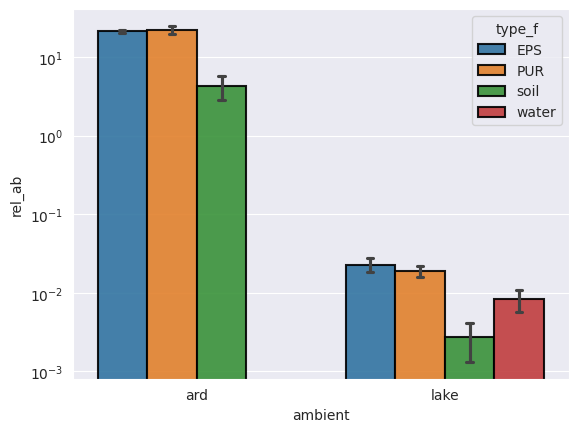

In [37]:
with sns.axes_style("darkgrid"):
    cat = sns.barplot(data = arg_general_sums,
                      x="ambient", y="rel_ab", alpha = 0.9,
                      errorbar = "se", capsize = 0.1, hue = "type_f",
                      fill = True, linewidth = 1.5, edgecolor = "black"
                     )
    plt.yscale("log")

plt.savefig("Site separated ARG log2 NCN-typef.png", bbox_inches= "tight")

In [38]:
summed_samples = all_data.groupby(["sample", "or_seq", "ambient", "type_g", "type_f"])["rel_ab"].sum().reset_index() #agrupa los datos según tipología. LO importante, también por nº de muestra
summed_samples["hacky"] = summed_samples["ambient"] + " " + summed_samples["type_g"]
summed_samples.sort_values(by = "hacky", inplace = True)
summed_samples["n_log2"] = np.log2(summed_samples["rel_ab"])
arg_general_sums = summed_samples.loc[summed_samples["or_seq"] == "arg"]
mge_general_sums = summed_samples.loc[summed_samples["or_seq"] == "mge"]

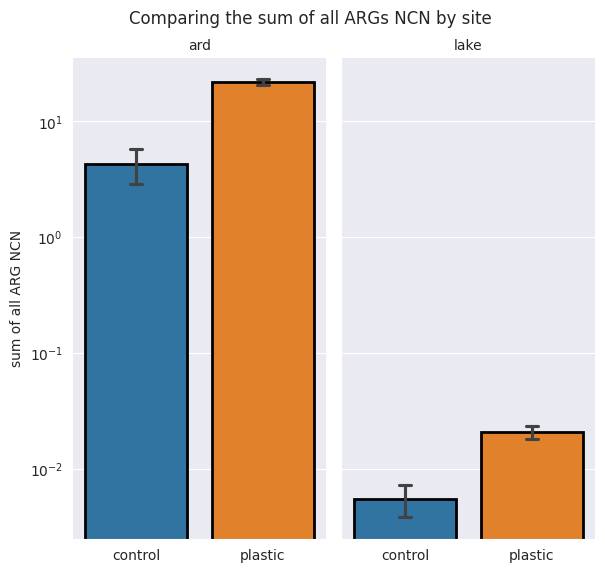

In [39]:
with sns.axes_style("darkgrid"):
    cat = sns.catplot(data = arg_general_sums, kind="bar",
                      x="type_g", y="rel_ab", col="ambient",
                      height=6, aspect=0.5,
                      errorbar = "se", capsize = 0.1, ecolor = "black", hue = "type_g",
                      fill = True,  edgecolor = "black", linewidth = 2
                    )
    cat.fig.subplots_adjust(top=0.9)
    cat.fig.suptitle('Comparing the sum of all ARGs NCN by site')
    cat.set_xlabels("")
    cat.set_ylabels("sum of all ARG NCN")
    #cat.map(sharey = False)
    plt.yscale("log")
    cat.set_titles("{col_name}")
plt.savefig("Site separated ARG log2 NCN.png", bbox_inches= "tight")

In [40]:
summed_samples = all_data.groupby(["sample", "or_seq", "ambient", "type_g", "type_f"])["rel_ab"].sum().reset_index() #agrupa los datos según tipología. LO importante, también por nº de muestra
summed_samples["hacky"] = summed_samples["ambient"] + " " + summed_samples["type_f"]
summed_samples.sort_values(by = "hacky", inplace = True)
summed_samples["n_log2"] = np.log2(summed_samples["rel_ab"])
arg_general_sums = summed_samples.loc[summed_samples["or_seq"] == "arg"]
mge_general_sums = summed_samples.loc[summed_samples["or_seq"] == "mge"]

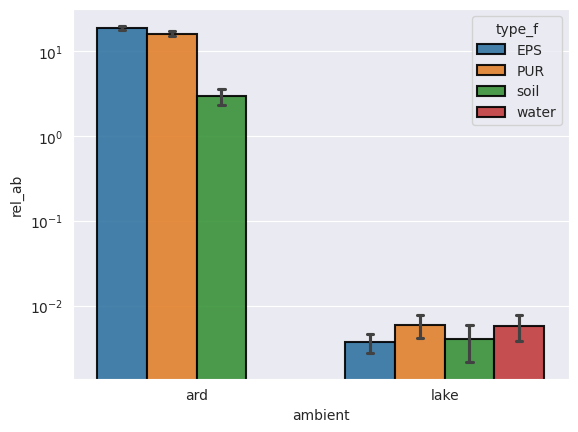

In [41]:
with sns.axes_style("darkgrid"):
    cat = sns.barplot(data = mge_general_sums,
                      x="ambient", y="rel_ab", alpha = 0.9,
                      errorbar = "se", capsize = 0.1, hue = "type_f",
                      fill = True, linewidth = 1.5, edgecolor = "black"
                     )
    plt.yscale("log")

plt.savefig("Site separated MGE log2 NCN-typef.png", bbox_inches= "tight")

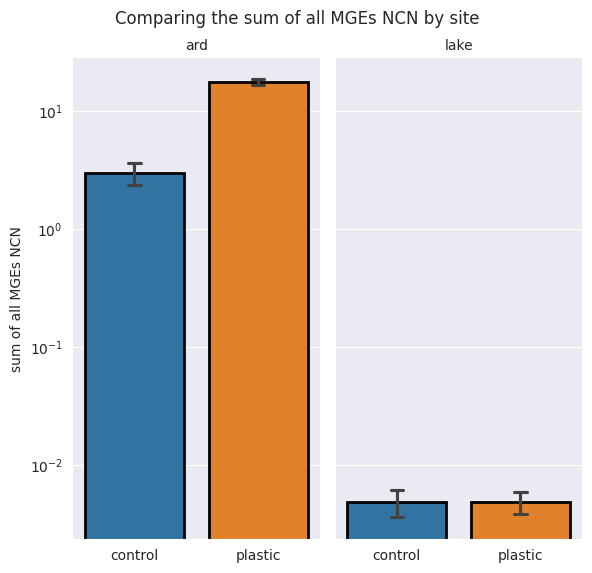

In [42]:
summed_samples = all_data.groupby(["sample", "or_seq", "ambient", "type_g", "type_f"])["rel_ab"].sum().reset_index() #agrupa los datos según tipología. LO importante, también por nº de muestra
summed_samples["hacky"] = summed_samples["ambient"] + " " + summed_samples["type_g"]
summed_samples.sort_values(by = "hacky", inplace = True)
summed_samples["n_log2"] = np.log2(summed_samples["rel_ab"])
arg_general_sums = summed_samples.loc[summed_samples["or_seq"] == "arg"]
mge_general_sums = summed_samples.loc[summed_samples["or_seq"] == "mge"]

with sns.axes_style("darkgrid"):
    cat = sns.catplot(data = mge_general_sums, kind="bar",
                      x="type_g", y="rel_ab", col="ambient",
                      height=6, aspect=0.5,
                      errorbar = "se", capsize = 0.1, ecolor = "black", hue = "type_g",
                      fill = True,  edgecolor = "black", linewidth = 2 
                    )
    cat.fig.subplots_adjust(top=0.9)
    cat.fig.suptitle('Comparing the sum of all MGEs NCN by site')
    cat.set_xlabels("")
    cat.set_ylabels("sum of all MGEs NCN")
    plt.yscale("log")
    cat.set_titles("{col_name}")
plt.savefig("Site separated MGE log2 NCN.png", bbox_inches= "tight")

## Datos diferenciados por familia

The idea here is to generate results on a per-family basis

In [29]:
%matplotlib agg
os.chdir(all_dir)
os.chdir("target_results_general")
typeg_dir = os.getcwd()
os.chdir("../target_results_fine")
typef_dir = os.getcwd()
for antib in all_data["antib"].unique():
    print("##### Working on ", antib.upper(), " #####")
    antib_data = all_data.loc[all_data["antib"] == antib]
    for grouping in ["type_g", "type_f"]:
        print (grouping.upper())
        if grouping == "type_g":
            os.chdir(typeg_dir)
        else:
            os.chdir(typef_dir)
        sp_grouped = antib_data.groupby(["sample", "ambient", grouping]) 
        summed_samples = sp_grouped["rel_ab"].sum() 
        summed_samples = summed_samples.reset_index() 
        summed_samples["n_log2"] = np.log2(summed_samples["rel_ab"])

        for ambient in summed_samples["ambient"].unique():
            print("Working on ", ambient.upper())
            ambient_samples = summed_samples.loc[summed_samples["ambient"] == ambient]
            var_lst = [group["rel_ab"] for name, group in ambient_samples.groupby([grouping])] 
            nam_lst = [name for name, group in ambient_samples.groupby([grouping])] 
            var_lst_ln = [group["n_log2"] for name, group in ambient_samples.groupby([grouping])]
            fname = antib.upper() + "-" + ambient.upper() + "-" + grouping.upper() + "-arg_group_statistics.txt"
            with open(fname, "w") as file:
                print("Regular_values: ", stats.levene(*var_lst), file = file)
                try:
                    print("Regular_kruskal: ", stats.kruskal(*var_lst), file = file)
                    print("Log2_kruskal: ", stats.kruskal(*var_lst_ln), file = file)
                    print("Log2_values: ", stats.levene(*var_lst_ln), file = file)
                except:
                    print("Log2_values: ", stats.levene(*var_lst_ln), file = file)     
        post_lolo = sp.posthoc_conover(var_lst, p_adjust = "fdr_bh")
        post_lolo.rename(columns = {original_num:new_name for (original_num, new_name) in zip(post_lolo.columns, nam_lst)},
                         index = {original_num:new_name for (original_num, new_name) in zip(post_lolo.index, nam_lst)},
                         inplace = True)
        post_lolo = post_lolo[post_lolo < 0.05]
        fname = antib.upper() + "-" + ambient.upper() + "-" + grouping.upper() + "all_arg_comparisions.csv"
        post_lolo.to_csv(fname)

        fname = antib + "--adjusted NCN sums.png"
        plot_title = "Comparing the sum of all " + antib.upper() + " NCNs by site"
    
        with sns.axes_style("darkgrid"):
            cat = sns.catplot(data = summed_samples, kind="bar",
                              x=grouping, y="rel_ab", col="ambient",
                              height=6, aspect=0.5,
                              errorbar = "se", capsize = 0.1, ecolor = "black", hue = grouping,
                              fill = True,  edgecolor = "black", linewidth = 2
                             )
            cat.fig.subplots_adjust(top=0.9)
            cat.fig.suptitle(plot_title)
            cat.set_xlabels("")
            cat.set_ylabels("sum of all NCNs")
            plt.yscale("log")
            cat.set_titles("{col_name}")
            plt.savefig(fname, bbox_inches= "tight")

##### Working on  AMINOGLYCOSIDE  #####
TYPE_G
Working on  LAKE
Working on  ARD
TYPE_F
Working on  LAKE
Working on  ARD
##### Working on  AMPHENICOL  #####
TYPE_G
Working on  LAKE
Working on  ARD
TYPE_F
Working on  LAKE
Working on  ARD
##### Working on  VANCOMYCIN  #####
TYPE_G
Working on  LAKE
Working on  ARD
TYPE_F
Working on  LAKE
Working on  ARD
##### Working on  BETA LACTAM  #####
TYPE_G
Working on  LAKE
Working on  ARD
TYPE_F
Working on  LAKE
Working on  ARD
##### Working on  MDR  #####
TYPE_G
Working on  LAKE
Working on  ARD
TYPE_F
Working on  LAKE
Working on  ARD
##### Working on  OTHER  #####
TYPE_G
Working on  LAKE
Working on  ARD
TYPE_F
Working on  LAKE
Working on  ARD
##### Working on  FLUOROQUINOLONE  #####
TYPE_G
Working on  LAKE
Working on  ARD
TYPE_F
Working on  LAKE
Working on  ARD
##### Working on  MLSB  #####
TYPE_G
Working on  LAKE
Working on  ARD
TYPE_F
Working on  LAKE
Working on  ARD
##### Working on  PHENICOL  #####
TYPE_G
Working on  LAKE
Working on  ARD
TYPE_F

## COMPARATIVA DEL Nº DE COPIA EN SÓLO LO DETECTADO

### SIN DIFERENCIAR POR PUNTO DE MUESTREO

Lo primero, quedarse sólo con los ARG/MGE que sean comunes tanto a plástico como a control

In [30]:
del all_data

In [31]:
os.chdir(data_dir)
all_data = pd.read_csv("ab_data_all_fixed.csv", index_col = 0)
all_data.dropna(inplace = True) 
all_data = all_data[(all_data["antib"] != "16S")]
all_data = all_data[["Assay", "antib", "sample", "place", "type_f", "type_g", "or_seq", "rel_ab"]] #place viene a ser la estrella del show
all_data = all_data.loc[~all_data["place"].isin([0])]
all_data.loc[all_data["sample"] == 13, "rel_ab"] = all_data.loc[all_data["sample"] == 13]["rel_ab"] / 3
all_data.loc[all_data["sample"] == 14, "rel_ab"] = all_data.loc[all_data["sample"] == 14]["rel_ab"] / 3
#all_data = all_data[(all_data.Assay != "aadA7") & (all_data.sample != 5)] #esto también es tremendamente importante

all_data.loc[all_data["place"] == "ardley", "ambient"] = "ard"
all_data.loc[all_data["place"] != "ardley", "ambient"] = "lake"
all_data.tail()

all_data.head()

,Assay,antib,sample,place,type_f,type_g,or_seq,rel_ab,ambient
0,aacC2,Aminoglycoside,25.0,ardley,PUR,plastic,arg,0.000222,ard
1,aacA/aphD,Aminoglycoside,25.0,ardley,PUR,plastic,arg,0.000046,ard
2,aac(6')-II,Aminoglycoside,25.0,ardley,PUR,plastic,arg,0.006918,ard
5,aac(6')-Ib,Aminoglycoside,25.0,ardley,PUR,plastic,arg,0.079250,ard
6,aadA2a,Aminoglycoside,25.0,ardley,PUR,plastic,arg,0.015205,ard


In [32]:
os.chdir(common_dir)
common_amps = all_data[["Assay", "place", "type_g"]].groupby(["place", "Assay"])["type_g"].unique()
common_amps = common_amps.reset_index()
common_amps["type_g"] = common_amps["type_g"].astype("str") #hacky as shit
common_amps = common_amps.loc[(common_amps["type_g"] == "['plastic' 'control']") | (common_amps["type_g"] == "['control' 'plastic']")]
common_amps = list(common_amps["Assay"].unique())
#common_amps

In [33]:
all_data = all_data.loc[all_data["Assay"].isin(common_amps)]
all_data

,Assay,antib,sample,place,type_f,type_g,or_seq,rel_ab,ambient
0,aacC2,Aminoglycoside,25.0,ardley,PUR,plastic,arg,0.000222,ard
6,aadA2a,Aminoglycoside,25.0,ardley,PUR,plastic,arg,0.015205,ard
7,aadA5,Aminoglycoside,25.0,ardley,PUR,plastic,arg,0.002472,ard
8,aadA_99,Aminoglycoside,25.0,ardley,PUR,plastic,arg,0.004207,ard
10,aadD,Aminoglycoside,25.0,ardley,PUR,plastic,arg,0.002742,ard
...,...,...,...,...,...,...,...,...,...
10126,qepA_1_2,Fluoroquinolone,14.0,ion,water,control,arg,0.000112,lake
10215,tetPA,Tetracycline,14.0,ion,water,control,arg,0.000168,lake
10231,intI1F165_clinical,Integrase,14.0,ion,water,control,mge,0.000391,lake
10240,czcA,MDR,14.0,ion,water,control,arg,0.004148,lake


In [34]:
general_grouped = all_data.groupby(["sample", "or_seq","type_g"]) #agrupa los datos según tipología. LO importante, también por nº de muestra
summed_samples = general_grouped["rel_ab"].sum() # y calcula la suma del nº de copias de todos los integrantes
summed_samples = summed_samples.reset_index()
summed_samples["n_log2"] = np.log2(summed_samples["rel_ab"])
summed_samples.replace([np.inf, -np.inf], np.nan, inplace=True)
summed_samples.dropna(inplace=True)
#summed_samples

In [35]:
general_difs = get_difs(summed_samples.groupby("or_seq"), var = "rel_ab", 
                        detailed = False, alternative = "two-sided", significant = True)
general_log_difs = get_difs(summed_samples.groupby("or_seq"), var = "n_log2", 
                        detailed = False, alternative = "two-sided", significant = True)
with open("pair_statistics.txt", "w") as file:
    print("Significant, NCN results: ", general_difs, file = file)
    print("Significant, log2 NCN results: ", general_log_difs, file = file)

In [36]:
var_lst = [group["rel_ab"] for name, group in summed_samples.groupby(["or_seq", "type_g"])] #contains every group
nam_lst = [name for name, group in summed_samples.groupby(["or_seq", "type_g"])] #contains the name of everygroup, SAME ORDER
print("Regular values: ", stats.levene(*var_lst))
var_lst_ln = [group["n_log2"] for name, group in summed_samples.groupby(["or_seq", "type_g"])]
print("Log2: ", stats.levene(*var_lst_ln))

Regular values:  LeveneResult(statistic=2.5307932762653484, pvalue=0.06763800390408137)
Log2:  LeveneResult(statistic=0.39912951953646597, pvalue=0.7542066855773506)


In [37]:
arg_general_sums = summed_samples.loc[summed_samples["or_seq"] == "arg"]
mge_general_sums = summed_samples.loc[summed_samples["or_seq"] == "mge"]

In [38]:
# Ahora posiciones de elementos decorativos
means_arg = [value for name, value in arg_general_sums.groupby("type_g")["rel_ab"].mean().items()] #esto es el valor de las medias pero lo usaré de posición
means_arg_log = [value for name, value in arg_general_sums.groupby("type_g")["n_log2"].mean().items()]
names = [name for name, value in summed_samples.groupby("type_g")["rel_ab"].mean().items()]
means_mge = [value for name, value in mge_general_sums.groupby("type_g")["rel_ab"].mean().items()]
means_mge_log = [value for name, value in mge_general_sums.groupby("type_g")["n_log2"].mean().items()]
print(means_arg)

[1.32980794436193, 6.260296337348691]


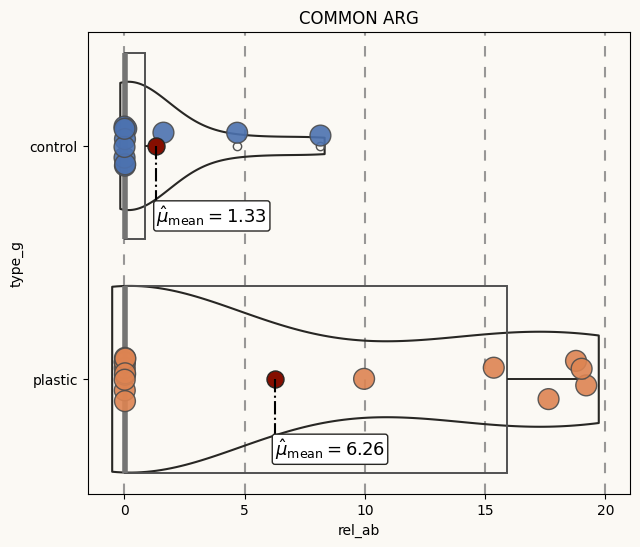

In [41]:
%matplotlib inline
hlines = [0, 5, 10, 15, 20]
make_chuli_plot_violin(data = arg_general_sums, 
                       x = "rel_ab",
                       y = "type_g",
                       mean_list = means_arg, line_list = hlines,
                       title = "COMMON ARG",
                       figsize = (7, 6),
                       )
plt.savefig("Common ARG.png", bbox_inches= "tight")

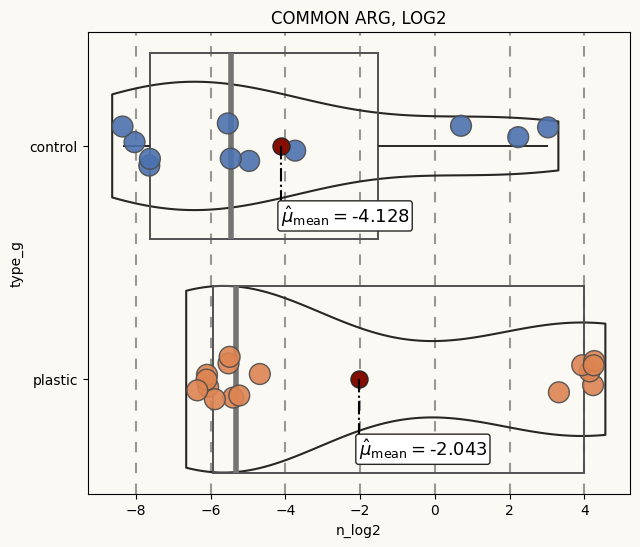

In [42]:
hlines_log = [-8, -6, -4, -2, 0, 2, 4]
make_chuli_plot_violin(data = arg_general_sums, 
                       x = "n_log2",
                       y = "type_g",
                       mean_list = means_arg_log, line_list = hlines_log,
                       title = "COMMON ARG, log2",
                       figsize = (7, 6),
                       )
plt.savefig("Common ARG, log2.png", bbox_inches= "tight")

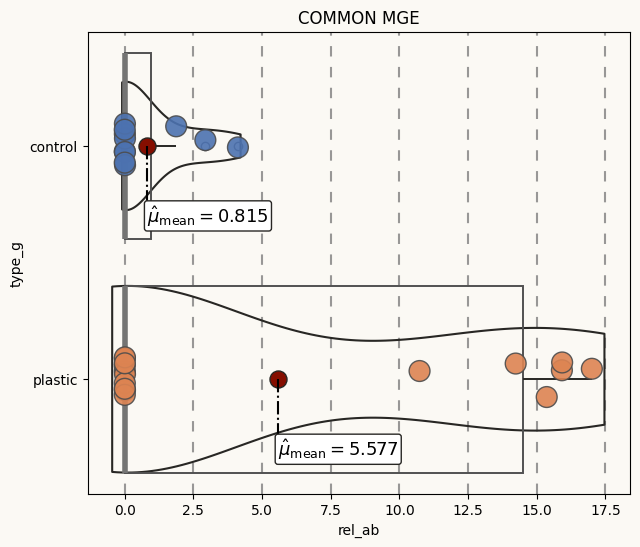

In [43]:
hlines = [0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5]
make_chuli_plot_violin(data = mge_general_sums, x = "rel_ab", y = "type_g", mean_list = means_mge, line_list = hlines, title = "common mge", figsize = (7, 6))
plt.savefig("Common MGE.png", bbox_inches= "tight")

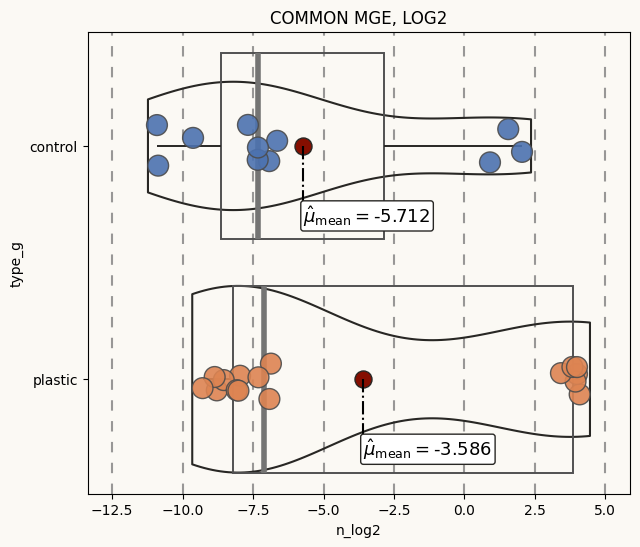

In [44]:
hlines_log = [-12.5, -10, -7.5, -5, -2.5, 0, 2.5, 5]
make_chuli_plot_violin(data = mge_general_sums, x = "n_log2", y = "type_g", mean_list = means_mge_log, line_list = hlines_log, title = "common mge, lOG2", figsize = (7, 6))
plt.savefig("Common MGE, log2.png", bbox_inches= "tight")

### DIFERENCIANDO POR PUNTO DE MUESTREO
Aquí la broma no es tan graciosa, porque tengo que ir viendo qué amplificaciones son comunes POR PUNTO DE MUESTREO. Un percal, vamos

In [45]:
del all_data

In [46]:
os.chdir(data_dir)
all_data = pd.read_csv("ab_data_all_fixed.csv", index_col = 0)
all_data.dropna(inplace = True)
all_data = all_data[(all_data["antib"] != "16S")]
all_data = all_data[["Assay", "antib", "sample", "place", "type_f", "type_g", "or_seq", "rel_ab"]] #place viene a ser la estrella del show
all_data = all_data.loc[~all_data["place"].isin([0])]
all_data.loc[all_data["sample"] == 13, "rel_ab"] = all_data.loc[all_data["sample"] == 13]["rel_ab"] / 3
all_data.loc[all_data["sample"] == 14, "rel_ab"] = all_data.loc[all_data["sample"] == 14]["rel_ab"] / 3
#all_data = all_data[(all_data.Assay != "aadA7") & (all_data.sample != 5)] #esto también es tremendamente importante

all_data.loc[all_data["place"] == "ardley", "ambient"] = "ard"
all_data.loc[all_data["place"] != "ardley", "ambient"] = "lake"
all_data.tail()

all_data.head()

,Assay,antib,sample,place,type_f,type_g,or_seq,rel_ab,ambient
0,aacC2,Aminoglycoside,25.0,ardley,PUR,plastic,arg,0.000222,ard
1,aacA/aphD,Aminoglycoside,25.0,ardley,PUR,plastic,arg,0.000046,ard
2,aac(6')-II,Aminoglycoside,25.0,ardley,PUR,plastic,arg,0.006918,ard
5,aac(6')-Ib,Aminoglycoside,25.0,ardley,PUR,plastic,arg,0.079250,ard
6,aadA2a,Aminoglycoside,25.0,ardley,PUR,plastic,arg,0.015205,ard


In [47]:
os.chdir(common_dir)
common_amps = all_data[["Assay", "place", "type_g"]].groupby(["place", "Assay"])["type_g"].unique()
common_amps = common_amps.reset_index()
common_amps["type_g"] = common_amps["type_g"].astype("str") #hacky as shit
common_amps = common_amps.loc[(common_amps["type_g"] == "['plastic' 'control']") | (common_amps["type_g"] == "['control' 'plastic']")]
common_amps

,place,Assay,type_g
0,ardley,ARR-3,['plastic' 'control']
1,ardley,Aac6-Aph2,['plastic' 'control']
3,ardley,Arr2,['plastic' 'control']
6,ardley,IS1133,['plastic' 'control']
7,ardley,IS1247,['plastic' 'control']
...,...,...,...
422,uru,mphA,['control' 'plastic']
423,uru,oprD,['plastic' 'control']
424,uru,orf37-IS26,['plastic' 'control']
426,uru,qepA_1_2,['plastic' 'control']


In [48]:
fixed_all = pd.DataFrame()
for sam_area in all_data["place"].unique():
    print("Working on: ", sam_area)
    sam_area_data = all_data.loc[all_data["place"] == sam_area]
    sam_area_data = sam_area_data.loc[sam_area_data["Assay"]
                                      .isin(list(common_amps.loc[common_amps["place"] == sam_area]["Assay"]
                                                 .unique()
                                                )
                                           )
                                     ]
    print("There's: ", len(sam_area_data["Assay"].unique()), "unique SHARED amps in ", sam_area)
    fixed_all = pd.concat([sam_area_data, fixed_all])
    del(sam_area_data)
fixed_all

Working on:  ardley
There's:  235 unique SHARED amps in  ardley
Working on:  ion
There's:  11 unique SHARED amps in  ion
Working on:  uru
There's:  15 unique SHARED amps in  uru


,Assay,antib,sample,place,type_f,type_g,or_seq,rel_ab,ambient
4259,aac3-Via,Aminoglycoside,7.0,uru,EPS,plastic,arg,0.009441,lake
4366,oprD,MDR,7.0,uru,EPS,plastic,arg,0.000264,lake
4376,mexB,MDR,7.0,uru,EPS,plastic,arg,0.000343,lake
4377,mdtg,MDR,7.0,uru,EPS,plastic,arg,0.000455,lake
4501,intI1F165_clinical,Integrase,7.0,uru,EPS,plastic,mge,0.002183,lake
...,...,...,...,...,...,...,...,...,...
3419,tnpAg,Transposase,21.0,ardley,soil,control,mge,0.000647,ard
3424,dfra21,Trimethoprim,21.0,ardley,soil,control,arg,0.089125,ard
3427,dfrA10,Trimethoprim,21.0,ardley,soil,control,arg,0.013428,ard
3433,dfrAB4,Trimethoprim,21.0,ardley,soil,control,arg,0.000095,ard


In [53]:
sp_grouped = fixed_all.groupby(["sample", "or_seq", "ambient", "type_g", "type_f"]) #agrupa los datos según tipología. LO importante, también por nº de muestra
summed_samples = sp_grouped["rel_ab"].sum() # y calcula la suma del nº de copias de todos los integrantes
summed_samples = summed_samples.reset_index() #aquí paso a df para facilitar el resto de pasos
summed_samples["n_log2"] = np.log2(summed_samples["rel_ab"])

# I want to separate ARGs and MGEs before checking for differences 
arg_general_sums = summed_samples.loc[summed_samples["or_seq"] == "arg"]
mge_general_sums = summed_samples.loc[summed_samples["or_seq"] == "mge"]
nam_arg_lst = [name for name, group in summed_samples.loc[summed_samples["or_seq"] == "arg"].groupby(["ambient", "type_g"])] #names will be useful in the pair comparision
nam_mge_lst = [name for name, group in summed_samples.loc[summed_samples["or_seq"] == "mge"].groupby(["ambient", "type_g"])]

#### General statistics

In [54]:
with open("group_statistics.txt", "w") as file:
    for seq_type in summed_samples["or_seq"].unique():
        seq_summed = summed_samples.loc[summed_samples["or_seq"] == seq_type]
        print("################", seq_type.upper(), "################", file = file)
        var_lst = [group["rel_ab"] for name, group in seq_summed.groupby(["or_seq", "ambient", "type_g"])] #contains every group
        print("Regular values: ", stats.levene(*var_lst), file = file)
        print("Regular Kruskal: ", stats.kruskal(*var_lst), file = file)
        var_lst_ln = [group["n_log2"] for name, group in arg_general_sums.groupby(["or_seq", "ambient", "type_g"])]
        print("Log2: ", stats.levene(*var_lst_ln), file = file)
        print("Log2 Kruskal: ", stats.kruskal(*var_lst_ln), file = file)

#### ARG multiple comparision

In [55]:
for grouping in ["type_g", "type_f"]:
    print("######## ", grouping.upper(), " ########")
    for ambient in arg_general_sums["ambient"].unique():
        print("Working on ", ambient.upper())
        ambient_samples = arg_general_sums.loc[arg_general_sums["ambient"] == ambient]
        var_lst = [group["rel_ab"] for name, group in ambient_samples.groupby([grouping])] #contains every group
        nam_lst = [name for name, group in ambient_samples.groupby([grouping])] #contains the name of everygroup, SAME ORDER
        print("Regular values: ", stats.levene(*var_lst))
        var_lst_ln = [group["n_log2"] for name, group in ambient_samples.groupby([grouping])]
        print("Log2: ", stats.levene(*var_lst_ln))
        fname = ambient.upper() + "-" + grouping.upper() +  "-arg_group_statistics.txt"
        with open(fname, "w") as file:
            print("Regular_values: ", stats.levene(*var_lst), file = file)
            print("Regular_kruskal: ", stats.kruskal(*var_lst), file = file)
            print("Log2_values: ", stats.levene(*var_lst_ln), file = file)
            print("Log2_kruskal: ", stats.kruskal(*var_lst_ln), file = file)
        print(stats.kruskal(*var_lst))
        post_lolo = sp.posthoc_conover(var_lst, p_adjust = "fdr_bh")

        # me interesa que los resultados del posthoc sean comprensibles sin tener que sustituir cada valor numérico de los ejes por su 
        # correspondiente nombre a mano. Para ello, puedo aprovechar la lista de nombres nam_lst y generar una lista de nº ordenados que
        # contengan todos los nºs del eje. O lo que es lo mismo, el index y las columnas
        post_lolo.rename(columns = {original_num:new_name for (original_num, new_name) in zip(post_lolo.columns, nam_lst)},
                         index = {original_num:new_name for (original_num, new_name) in zip(post_lolo.index, nam_lst)},
                         inplace = True)

        # Y ahora ver solo lo interesante
        post_lolo = post_lolo[post_lolo < 0.05]
        fname = ambient.upper() + "-" + grouping.upper() +  "-common_arg_comparisions.csv"
        post_lolo.to_csv(fname)
        print(post_lolo)


########  TYPE_G  ########
Working on  LAKE
Regular values:  LeveneResult(statistic=3.506185459489389, pvalue=0.07953196614096654)
Log2:  LeveneResult(statistic=18.734779974846763, pvalue=0.0005190638667687403)
KruskalResult(statistic=0.19736842105263008, pvalue=0.6568534184528312)
            (control,)  (plastic,)
(control,)         NaN         NaN
(plastic,)         NaN         NaN
Working on  ARD
Regular values:  LeveneResult(statistic=0.14913676635178005, pvalue=0.7108312022559617)
Log2:  LeveneResult(statistic=2.7013162798519352, pvalue=0.14426572123532175)
KruskalResult(statistic=4.266666666666666, pvalue=0.038867103812417335)
            (control,)  (plastic,)
(control,)         NaN    0.025464
(plastic,)    0.025464         NaN
########  TYPE_F  ########
Working on  LAKE
Regular values:  LeveneResult(statistic=2.2860866180198802, pvalue=0.12342051172308739)
Log2:  LeveneResult(statistic=1.0895271291596307, pvalue=0.38584695647502676)
KruskalResult(statistic=6.4684210526315695,

#### MGE multiple comparision

In [56]:
for grouping in ["type_g", "type_f"]:
    print("######## ", grouping.upper(), " ########")
    for ambient in mge_general_sums["ambient"].unique():
        print("Working on ", ambient.upper())
        ambient_samples = arg_general_sums.loc[summed_samples["ambient"] == ambient]
        var_lst = [group["rel_ab"] for name, group in ambient_samples.groupby([grouping])] #contains every group
        nam_lst = [name for name, group in ambient_samples.groupby([grouping])] #contains the name of everygroup, SAME ORDER
        print("Regular values: ", stats.levene(*var_lst))
        var_lst_ln = [group["n_log2"] for name, group in ambient_samples.groupby([grouping])]
        print("Log2: ", stats.levene(*var_lst_ln))
        fname = ambient.upper() + "-" + grouping.upper() +  "-mge_group_statistics.txt"
        with open(fname, "w") as file:
            print("Regular_values: ", stats.levene(*var_lst), file = file)
            print("Regular_kruskal: ", stats.kruskal(*var_lst), file = file)
            print("Log2_values: ", stats.levene(*var_lst_ln), file = file)
            print("Log2_kruskal: ", stats.kruskal(*var_lst_ln), file = file)
        print(stats.kruskal(*var_lst))
        post_lolo = sp.posthoc_conover(var_lst, p_adjust = "fdr_bh")

        # me interesa que los resultados del posthoc sean comprensibles sin tener que sustituir cada valor numérico de los ejes por su 
        # correspondiente nombre a mano. Para ello, puedo aprovechar la lista de nombres nam_lst y generar una lista de nº ordenados que
        # contengan todos los nºs del eje. O lo que es lo mismo, el index y las columnas
        post_lolo.rename(columns = {original_num:new_name for (original_num, new_name) in zip(post_lolo.columns, nam_lst)},
                         index = {original_num:new_name for (original_num, new_name) in zip(post_lolo.index, nam_lst)},
                         inplace = True)

        # Y ahora ver solo lo interesante
        post_lolo = post_lolo[post_lolo < 0.05]
        fname = ambient.upper() + "-" + grouping.upper() +  "-common_mge_comparisions.csv"
        post_lolo.to_csv(fname)
        print(post_lolo)

########  TYPE_G  ########
Working on  LAKE
Regular values:  LeveneResult(statistic=3.506185459489389, pvalue=0.07953196614096654)
Log2:  LeveneResult(statistic=18.734779974846763, pvalue=0.0005190638667687403)
KruskalResult(statistic=0.19736842105263008, pvalue=0.6568534184528312)
            (control,)  (plastic,)
(control,)         NaN         NaN
(plastic,)         NaN         NaN
Working on  ARD
Regular values:  LeveneResult(statistic=0.14913676635178005, pvalue=0.7108312022559617)
Log2:  LeveneResult(statistic=2.7013162798519352, pvalue=0.14426572123532175)
KruskalResult(statistic=4.266666666666666, pvalue=0.038867103812417335)
            (control,)  (plastic,)
(control,)         NaN    0.025464
(plastic,)    0.025464         NaN
########  TYPE_F  ########
Working on  LAKE
Regular values:  LeveneResult(statistic=2.2860866180198802, pvalue=0.12342051172308739)
Log2:  LeveneResult(statistic=1.0895271291596307, pvalue=0.38584695647502676)
KruskalResult(statistic=6.4684210526315695,

#### graphs

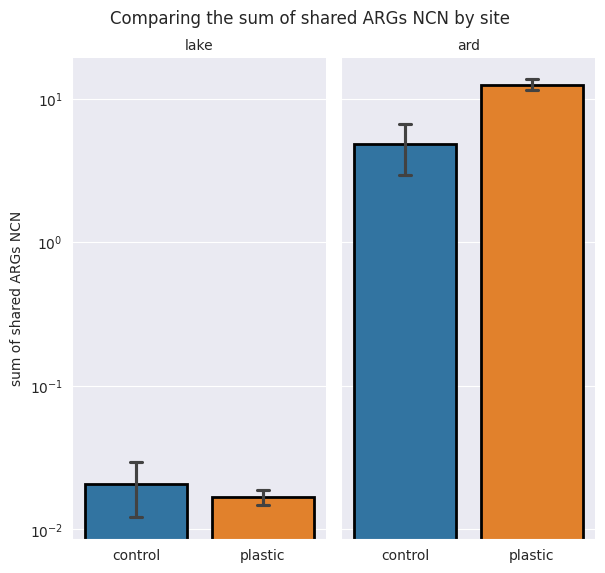

In [76]:
with sns.axes_style("darkgrid"):
    cat = sns.catplot(data = arg_general_sums, kind="bar",
                      x="type_g", y="rel_ab", col="ambient",
                      height=6, aspect=0.5, hue = "type_g",
                      errorbar = "se", capsize = 0.1, ecolor = "black",
                      fill = True,  edgecolor = "black", linewidth = 2 
                    )
    cat.fig.subplots_adjust(top=0.9)
    cat.fig.suptitle('Comparing the sum of shared ARGs NCN by site')
    cat.set_xlabels("")
    cat.set_ylabels("sum of shared ARGs NCN")
    plt.yscale("log")
    cat.set_titles("{col_name}")
plt.savefig("Site separated shared ARGs NCN.png", bbox_inches= "tight")

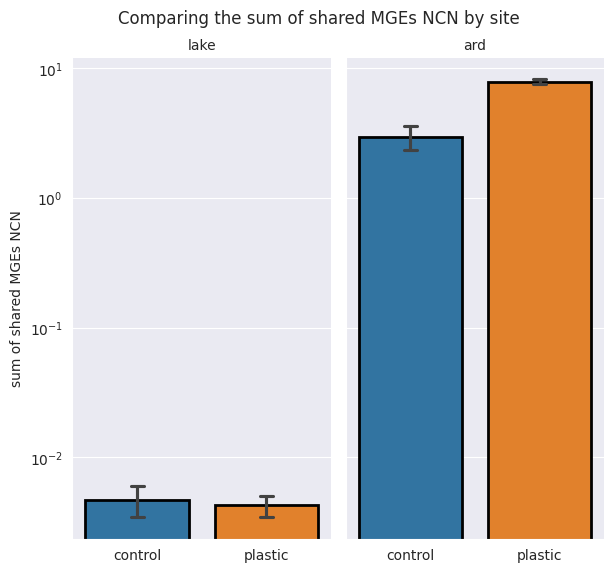

In [77]:
sns.set_palette("tab10")

with sns.axes_style("darkgrid"):
    cat = sns.catplot(data = mge_general_sums, kind="bar",
                      x="type_g", y="rel_ab", col="ambient",
                      height=6, aspect=0.5, hue = "type_g",
                      errorbar = "se", capsize = 0.1, ecolor = "black",
                      fill = True,  edgecolor = "black", linewidth = 2
                    )
    cat.fig.subplots_adjust(top=0.9)
    cat.fig.suptitle('Comparing the sum of shared MGEs NCN by site')
    cat.set_xlabels("")
    cat.set_ylabels("sum of shared MGEs NCN")
    cat.set_titles("{col_name}")
    plt.yscale("log")
plt.savefig("Site separated shared MGEs NCN.png", bbox_inches= "tight")

### Datos diferenciados por familia

In [78]:
%matplotlib agg
os.chdir(common_dir)
os.chdir("target_results_general")
typeg_dir = os.getcwd()
os.chdir("../target_results_fine")
typef_dir = os.getcwd()
for antib in fixed_all["antib"].unique():
    print("##### Working on ", antib.upper(), " #####")
    antib_data = fixed_all.loc[fixed_all["antib"] == antib]
    for grouping in ["type_g", "type_f"]:
        print (grouping.upper())
        if grouping == "type_g":
            os.chdir(typeg_dir)
        else:
            os.chdir(typef_dir)
        sp_grouped = antib_data.groupby(["sample", "ambient", grouping]) 
        summed_samples = sp_grouped["rel_ab"].sum() 
        summed_samples = summed_samples.reset_index() 
        summed_samples["n_log2"] = np.log2(summed_samples["rel_ab"])

        for ambient in summed_samples["ambient"].unique():
            print("Working on ", ambient.upper())
            ambient_samples = summed_samples.loc[summed_samples["ambient"] == ambient]
            var_lst = [group["rel_ab"] for name, group in ambient_samples.groupby([grouping])] 
            nam_lst = [name for name, group in ambient_samples.groupby([grouping])] 
            var_lst_ln = [group["n_log2"] for name, group in ambient_samples.groupby([grouping])]
            fname = antib.upper() + "-" + ambient.upper() + "-" + grouping.upper() + "-arg_group_statistics.txt"
            with open(fname, "w") as file:
                print("Regular_values: ", stats.levene(*var_lst), file = file)
                try:
                    print("Regular_kruskal: ", stats.kruskal(*var_lst), file = file)
                    print("Log2_kruskal: ", stats.kruskal(*var_lst_ln), file = file)
                    print("Log2_values: ", stats.levene(*var_lst_ln), file = file)
                except:
                    print("Log2_values: ", stats.levene(*var_lst_ln), file = file)     
        post_lolo = sp.posthoc_conover(var_lst, p_adjust = "fdr_bh")
        post_lolo.rename(columns = {original_num:new_name for (original_num, new_name) in zip(post_lolo.columns, nam_lst)},
                         index = {original_num:new_name for (original_num, new_name) in zip(post_lolo.index, nam_lst)},
                         inplace = True)
        post_lolo = post_lolo[post_lolo < 0.05]
        fname = antib.upper() + "-" + ambient.upper() + "-" + grouping.upper() + "all_arg_comparisions.csv"
        post_lolo.to_csv(fname)

        fname = antib + "--adjusted NCN sums.png"
        plot_title = "Comparing the sum of all " + antib.upper() + " NCNs by site"
    
        with sns.axes_style("darkgrid"):
            cat = sns.catplot(data = summed_samples, kind="bar",
                              x=grouping, y="rel_ab", col="ambient",
                              height=6, aspect=0.5,
                              errorbar = "se", capsize = 0.1, ecolor = "black", hue = grouping,
                              fill = True,  edgecolor = "black", linewidth = 2
                             )
            cat.fig.subplots_adjust(top=0.9)
            cat.fig.suptitle(plot_title)
            cat.set_xlabels("")
            cat.set_ylabels("sum of all NCNs")
            plt.yscale("log")
            cat.set_titles("{col_name}")
            plt.savefig(fname, bbox_inches= "tight")

##### Working on  AMINOGLYCOSIDE  #####
TYPE_G
Working on  LAKE
Working on  ARD
TYPE_F
Working on  LAKE
Working on  ARD
##### Working on  MDR  #####
TYPE_G
Working on  LAKE
Working on  ARD
TYPE_F
Working on  LAKE
Working on  ARD
##### Working on  INTEGRASE  #####
TYPE_G
Working on  LAKE
Working on  ARD
TYPE_F
Working on  LAKE
Working on  ARD
##### Working on  PLASMID  #####
TYPE_G
Working on  LAKE
Working on  ARD
TYPE_F
Working on  LAKE
Working on  ARD
##### Working on  PLASMID-INC  #####
TYPE_G
Working on  LAKE
Working on  ARD
TYPE_F
Working on  LAKE
Working on  ARD
##### Working on  FLUOROQUINOLONE  #####
TYPE_G
Working on  LAKE
Working on  ARD
TYPE_F
Working on  LAKE
Working on  ARD
##### Working on  BETA LACTAM  #####
TYPE_G
Working on  LAKE
Working on  ARD
TYPE_F
Working on  LAKE
Working on  ARD
##### Working on  INSERTIONAL  #####
TYPE_G
Working on  LAKE
Working on  ARD
TYPE_F
Working on  LAKE
Working on  ARD
##### Working on  MLSB  #####
TYPE_G
Working on  LAKE
Working on  ARD
T

## COMPARATIVA AJUSTANDO EL NCN AL Nº DE DETECCIONES EN SÓLO LO DETECTADO

Misma idea que antes, pero si en los lagos hay 20 detecciones comunes y en ardley 200, divido lo de los lagos entre 20 y lo de ardley entre 200. Una especie de media ajustada, no sabría como denominarla

In [57]:
del all_data

os.chdir(data_dir)
all_data = pd.read_csv("ab_data_all_fixed.csv", index_col = 0)
all_data.dropna(inplace = True)
all_data = all_data[(all_data["antib"] != "16S")]
all_data = all_data[["Assay", "antib", "sample", "place", "type_f", "type_g", "or_seq", "rel_ab"]] #place viene a ser la estrella del show
all_data = all_data.loc[~all_data["place"].isin([0])]
all_data.loc[all_data["sample"] == 13, "rel_ab"] = all_data.loc[all_data["sample"] == 13]["rel_ab"] / 3
all_data.loc[all_data["sample"] == 14, "rel_ab"] = all_data.loc[all_data["sample"] == 14]["rel_ab"] / 3
#all_data = all_data[(all_data.Assay != "aadA7") & (all_data.sample != 5)] #esto también es tremendamente importante

fix_a7_1 = all_data.loc[(all_data["Assay"] == "aadA7") & (all_data["sample"] == 4)]["rel_ab"]
fix_a7_2 = all_data.loc[(all_data["Assay"] == "aadA7") & (all_data["sample"] == 6)]["rel_ab"]
fix = (float(fix_a7_1) + float(fix_a7_2))/2


#all_data.loc[(all_data["Assay"] == "aadA7") & (all_data["sample"] == 5), "rel_ab"] = fix
all_data.loc[all_data["place"] == "ardley", "ambient"] = "ard"
all_data.loc[all_data["place"] != "ardley", "ambient"] = "lake"

os.chdir(ca_dir)

#all_data = all_data.loc[all_data["ambient"] == "lake"]
#lala = ((all_data.loc[(all_data.Assay == "aadA7") & (all_data.sample == 4)]) + (all_data.loc[(all_data.Assay == "aadA7") & (all_data.sample == 6)]))/2

#print((float(fix_a7_1) + float(fix_a7_2))/2)
#print(fix_a7_1)
#all_data

In [58]:
common_amps = all_data[["Assay", "place", "type_g"]].groupby(["place", "Assay"])["type_g"].unique()
common_amps = common_amps.reset_index()
common_amps["type_g"] = common_amps["type_g"].astype("str") #hacky as shit
common_amps = common_amps.loc[(common_amps["type_g"] == "['plastic' 'control']") | (common_amps["type_g"] == "['control' 'plastic']")]
common_amps

,place,Assay,type_g
0,ardley,ARR-3,['plastic' 'control']
1,ardley,Aac6-Aph2,['plastic' 'control']
3,ardley,Arr2,['plastic' 'control']
6,ardley,IS1133,['plastic' 'control']
7,ardley,IS1247,['plastic' 'control']
...,...,...,...
422,uru,mphA,['control' 'plastic']
423,uru,oprD,['plastic' 'control']
424,uru,orf37-IS26,['plastic' 'control']
426,uru,qepA_1_2,['plastic' 'control']


In [59]:
fixed_all = pd.DataFrame()
for sam_area in all_data["place"].unique():
    print("Working on: ", sam_area)
    sam_area_data = all_data.loc[all_data["place"] == sam_area]
    sam_area_data = sam_area_data.loc[sam_area_data["Assay"]
                                      .isin(list(common_amps.loc[common_amps["place"] == sam_area]["Assay"]
                                                 .unique()
                                                )
                                           )
                                     ]
    print("There's: ", len(sam_area_data["Assay"].unique()), "unique SHARED amps in ", sam_area)
    fixed_all = pd.concat([sam_area_data, fixed_all])
    del(sam_area_data)
fixed_all

Working on:  ardley
There's:  235 unique SHARED amps in  ardley
Working on:  ion
There's:  11 unique SHARED amps in  ion
Working on:  uru
There's:  15 unique SHARED amps in  uru


,Assay,antib,sample,place,type_f,type_g,or_seq,rel_ab,ambient
4259,aac3-Via,Aminoglycoside,7.0,uru,EPS,plastic,arg,0.009441,lake
4366,oprD,MDR,7.0,uru,EPS,plastic,arg,0.000264,lake
4376,mexB,MDR,7.0,uru,EPS,plastic,arg,0.000343,lake
4377,mdtg,MDR,7.0,uru,EPS,plastic,arg,0.000455,lake
4501,intI1F165_clinical,Integrase,7.0,uru,EPS,plastic,mge,0.002183,lake
...,...,...,...,...,...,...,...,...,...
3419,tnpAg,Transposase,21.0,ardley,soil,control,mge,0.000647,ard
3424,dfra21,Trimethoprim,21.0,ardley,soil,control,arg,0.089125,ard
3427,dfrA10,Trimethoprim,21.0,ardley,soil,control,arg,0.013428,ard
3433,dfrAB4,Trimethoprim,21.0,ardley,soil,control,arg,0.000095,ard


In [60]:
# This will add a new column named "adjust" in which the number of unique, shared between control and plastic sequences for each specific area and sequence type will be kept
for place in fixed_all["place"].unique():
    #print(place)
    for or_seq in fixed_all["or_seq"].unique():
        #print(or_seq)
        temp_counts = len(fixed_all.loc[(fixed_all["place"] == place) & (fixed_all["or_seq"] == or_seq)]["Assay"].unique())
        fixed_all.loc[(fixed_all["place"] == place) & (fixed_all["or_seq"] == or_seq), "adjust"] = temp_counts
        print("There's: ", temp_counts, "unique, shared between plastic and control", or_seq, "sequences in ", place)
        del temp_counts

fixed_all

There's:  10 unique, shared between plastic and control arg sequences in  uru
There's:  5 unique, shared between plastic and control mge sequences in  uru
There's:  7 unique, shared between plastic and control arg sequences in  ion
There's:  4 unique, shared between plastic and control mge sequences in  ion
There's:  192 unique, shared between plastic and control arg sequences in  ardley
There's:  43 unique, shared between plastic and control mge sequences in  ardley


,Assay,antib,sample,place,type_f,type_g,or_seq,rel_ab,ambient,adjust
4259,aac3-Via,Aminoglycoside,7.0,uru,EPS,plastic,arg,0.009441,lake,10.0
4366,oprD,MDR,7.0,uru,EPS,plastic,arg,0.000264,lake,10.0
4376,mexB,MDR,7.0,uru,EPS,plastic,arg,0.000343,lake,10.0
4377,mdtg,MDR,7.0,uru,EPS,plastic,arg,0.000455,lake,10.0
4501,intI1F165_clinical,Integrase,7.0,uru,EPS,plastic,mge,0.002183,lake,5.0
...,...,...,...,...,...,...,...,...,...,...
3419,tnpAg,Transposase,21.0,ardley,soil,control,mge,0.000647,ard,43.0
3424,dfra21,Trimethoprim,21.0,ardley,soil,control,arg,0.089125,ard,192.0
3427,dfrA10,Trimethoprim,21.0,ardley,soil,control,arg,0.013428,ard,192.0
3433,dfrAB4,Trimethoprim,21.0,ardley,soil,control,arg,0.000095,ard,192.0


In [71]:
sp_grouped = fixed_all.groupby(["sample", "or_seq", "place", "ambient", "type_g", "type_f"]) #agrupa los datos según tipología. LO importante, también por nº de muestra
summed_samples = sp_grouped["rel_ab"].sum() # y calcula la suma del nº de copias de todos los integrantes
summed_samples = summed_samples.reset_index() #aquí paso a df para facilitar el resto de pasos

for place in summed_samples["place"].unique():
    for or_seq in summed_samples["or_seq"].unique():
        # Get the adjust value from before
        summed_samples.loc[(summed_samples["place"] == place) & (summed_samples["or_seq"] == or_seq), "adjust"] = int(fixed_all.loc[(fixed_all["place"] == place) & (fixed_all["or_seq"] == or_seq)]["adjust"].unique())

# Adjust the NCN value. Adjusted Summed NCN = asn
summed_samples["asn"] = summed_samples["rel_ab"] / summed_samples["adjust"]
summed_samples["n_log2"] = np.log2(summed_samples["asn"])        
summed_samples.head()

,sample,or_seq,place,ambient,type_g,type_f,rel_ab,adjust,asn,n_log2
0,1.0,arg,uru,lake,control,soil,0.019795,10.0,0.001979,-8.980674
1,1.0,mge,uru,lake,control,soil,0.004868,5.0,0.000974,-10.004505
2,2.0,arg,uru,lake,control,soil,0.003814,10.0,0.000381,-11.356255
3,2.0,mge,uru,lake,control,soil,0.001262,5.0,0.000252,-11.952300
4,3.0,arg,uru,lake,control,soil,0.005013,10.0,0.000501,-10.962133


### SIN DIFERENCIAR POR PUNTO DE MUESTREO

In [72]:
general_difs = get_difs(summed_samples.groupby("or_seq"), var = "asn", 
                        detailed = False, alternative = "two-sided", significant = True)
general_log_difs = get_difs(summed_samples.groupby("or_seq"), var = "n_log2", 
                        detailed = False, alternative = "two-sided", significant = True)
with open("pair_statistics.txt", "w") as file:
    print("Significant, NCN results: ", general_difs, file = file)
    print("Significant, log2 NCN results: ", general_log_difs, file = file)

In [73]:
arg_general_sums = summed_samples.loc[summed_samples["or_seq"] == "arg"]
mge_general_sums = summed_samples.loc[summed_samples["or_seq"] == "mge"]

means_arg = [value for name, value in arg_general_sums.groupby("type_g")["asn"].mean().items()] #esto es el valor de las medias pero lo usaré de posición
means_arg_log = [value for name, value in arg_general_sums.groupby("type_g")["n_log2"].mean().items()]
names = [name for name, value in summed_samples.groupby("type_g")["asn"].mean().items()]
means_mge = [value for name, value in mge_general_sums.groupby("type_g")["asn"].mean().items()]
means_mge_log = [value for name, value in mge_general_sums.groupby("type_g")["n_log2"].mean().items()]

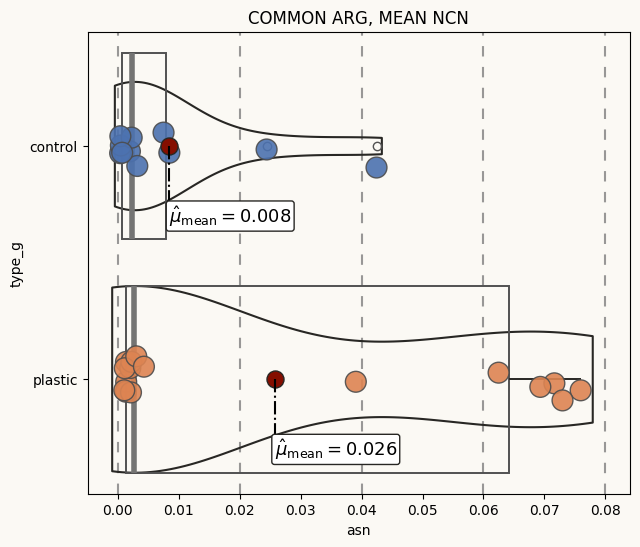

In [74]:
%matplotlib inline
%matplotlib inline
hlines = [0, 0.02, 0.04, 0.06, 0.08]
make_chuli_plot_violin(data = arg_general_sums, 
                       x = "asn",
                       y = "type_g",
                       mean_list = means_arg, line_list = hlines,
                       title = "common arg, mean ncn",
                       figsize = (7, 6),
                       )
plt.savefig("Common ARG, adjusted NCN.png", bbox_inches= "tight")

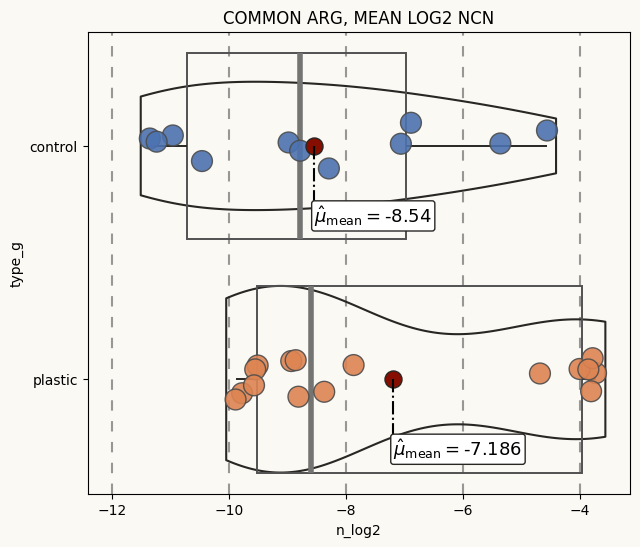

In [65]:
hlines_log = [-12, -10, -8, -6, -4]
make_chuli_plot_violin(data = arg_general_sums, 
                       x = "n_log2",
                       y = "type_g",
                       mean_list = means_arg_log, line_list = hlines_log,
                       title = "common arg, mean log2 NCN",
                       figsize = (7, 6),
                       )
plt.savefig("Common ARG, adjusted log2 NCN.png", bbox_inches= "tight")

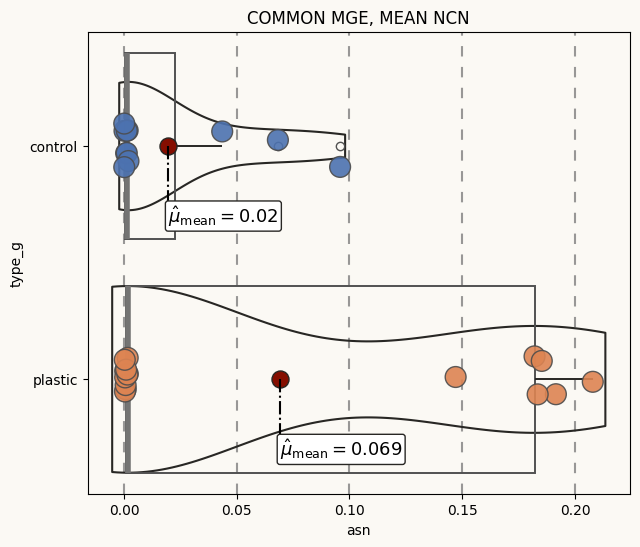

In [66]:
hlines = [0, 0.05, 0.10, 0.15, 0.20]
make_chuli_plot_violin(data = mge_general_sums, 
                       x = "asn",
                       y = "type_g",
                       mean_list = means_mge, line_list = hlines,
                       title = "common mge, MEAN NCN",
                       figsize = (7, 6),
                       )
plt.savefig("Common MGE, adjusted NCN.png", bbox_inches= "tight")

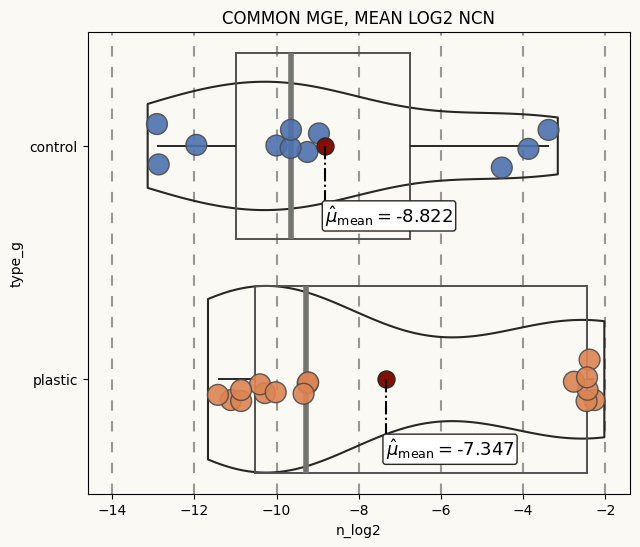

In [67]:
hlines_log = [-14, -12, -10, -8, -6, -4, -2]
make_chuli_plot_violin(data = mge_general_sums, 
                       x = "n_log2",
                       y = "type_g",
                       mean_list = means_mge_log, line_list = hlines_log,
                       title = "common mge, MEAN LOG2 NCN",
                       figsize = (7, 6),
                       )
plt.savefig("Common MGE, adjusted log2 NCN.png", bbox_inches= "tight")

Como podemos ver, no sólo es que se mantengan las conclusiones generales (habiendo corregido el posible ese factor distorsionador del distinto nº de amplificaciones), sino que incluso parecen exacerbarse.

### SEPARANDO POR PUNTO DE MUESTREO

#### General statistics

In [75]:
with open("group_statistics.txt", "w") as file:
    for seq_type in summed_samples["or_seq"].unique():
        seq_summed = summed_samples.loc[summed_samples["or_seq"] == seq_type]
        print("################", seq_type.upper(), "################", file = file)
        var_lst = [group["asn"] for name, group in seq_summed.groupby(["or_seq", "ambient", "type_g"])] #contains every group
        print("Regular values: ", stats.levene(*var_lst), file = file)
        print("Regular Kruskal: ", stats.kruskal(*var_lst), file = file)
        var_lst_ln = [group["n_log2"] for name, group in arg_general_sums.groupby(["or_seq", "ambient", "type_g"])]
        print("Log2: ", stats.levene(*var_lst_ln), file = file)
        print("Log2 Kruskal: ", stats.kruskal(*var_lst_ln), file = file)

#### ARG multiple comparision

In [76]:
for grouping in ["type_g", "type_f"]:
    print("######## ", grouping.upper(), " ########")
    for ambient in arg_general_sums["ambient"].unique():
        print("Working on ", ambient.upper())
        ambient_samples = arg_general_sums.loc[arg_general_sums["ambient"] == ambient]
        var_lst = [group["rel_ab"] for name, group in ambient_samples.groupby([grouping])] #contains every group
        nam_lst = [name for name, group in ambient_samples.groupby([grouping])] #contains the name of everygroup, SAME ORDER
        print("Regular values: ", stats.levene(*var_lst))
        var_lst_ln = [group["n_log2"] for name, group in ambient_samples.groupby([grouping])]
        print("Log2: ", stats.levene(*var_lst_ln))
        fname = ambient.upper() + "-" + grouping.upper() +  "-arg_group_statistics.txt"
        with open(fname, "w") as file:
            print("Regular_values: ", stats.levene(*var_lst), file = file)
            print("Regular_kruskal: ", stats.kruskal(*var_lst), file = file)
            print("Log2_values: ", stats.levene(*var_lst_ln), file = file)
            print("Log2_kruskal: ", stats.kruskal(*var_lst_ln), file = file)
        print(stats.kruskal(*var_lst))
        post_lolo = sp.posthoc_conover(var_lst, p_adjust = "fdr_bh")

        # me interesa que los resultados del posthoc sean comprensibles sin tener que sustituir cada valor numérico de los ejes por su 
        # correspondiente nombre a mano. Para ello, puedo aprovechar la lista de nombres nam_lst y generar una lista de nº ordenados que
        # contengan todos los nºs del eje. O lo que es lo mismo, el index y las columnas
        post_lolo.rename(columns = {original_num:new_name for (original_num, new_name) in zip(post_lolo.columns, nam_lst)},
                         index = {original_num:new_name for (original_num, new_name) in zip(post_lolo.index, nam_lst)},
                         inplace = True)

        # Y ahora ver solo lo interesante
        post_lolo = post_lolo[post_lolo < 0.05]
        fname = ambient.upper() + "-" + grouping.upper() +  "-common_arg_comparisions.csv"
        post_lolo.to_csv(fname)
        print(post_lolo)

########  TYPE_G  ########
Working on  LAKE
Regular values:  LeveneResult(statistic=3.506185459489389, pvalue=0.07953196614096654)
Log2:  LeveneResult(statistic=12.543513085052261, pvalue=0.0027137787565838325)
KruskalResult(statistic=0.19736842105263008, pvalue=0.6568534184528312)
            (control,)  (plastic,)
(control,)         NaN         NaN
(plastic,)         NaN         NaN
Working on  ARD
Regular values:  LeveneResult(statistic=0.14913676635178005, pvalue=0.7108312022559617)
Log2:  LeveneResult(statistic=2.7013162798519343, pvalue=0.14426572123532186)
KruskalResult(statistic=4.266666666666666, pvalue=0.038867103812417335)
            (control,)  (plastic,)
(control,)         NaN    0.025464
(plastic,)    0.025464         NaN
########  TYPE_F  ########
Working on  LAKE
Regular values:  LeveneResult(statistic=2.2860866180198802, pvalue=0.12342051172308739)
Log2:  LeveneResult(statistic=0.5895314077872508, pvalue=0.6319064575233412)
KruskalResult(statistic=6.4684210526315695, 

#### MGE multiple comparision

In [77]:
for grouping in ["type_g", "type_f"]:
    print("######## ", grouping.upper(), " ########")
    for ambient in mge_general_sums["ambient"].unique():
        print("Working on ", ambient.upper())
        ambient_samples = mge_general_sums.loc[mge_general_sums["ambient"] == ambient]
        var_lst = [group["rel_ab"] for name, group in ambient_samples.groupby([grouping])] #contains every group
        nam_lst = [name for name, group in ambient_samples.groupby([grouping])] #contains the name of everygroup, SAME ORDER
        print("Regular values: ", stats.levene(*var_lst))
        var_lst_ln = [group["n_log2"] for name, group in ambient_samples.groupby([grouping])]
        print("Log2: ", stats.levene(*var_lst_ln))
        fname = ambient.upper() + "-" + grouping.upper() +  "-arg_group_statistics.txt"
        with open(fname, "w") as file:
            print("Regular_values: ", stats.levene(*var_lst), file = file)
            print("Regular_kruskal: ", stats.kruskal(*var_lst), file = file)
            print("Log2_values: ", stats.levene(*var_lst_ln), file = file)
            print("Log2_kruskal: ", stats.kruskal(*var_lst_ln), file = file)
        print(stats.kruskal(*var_lst))
        post_lolo = sp.posthoc_conover(var_lst, p_adjust = "fdr_bh")

        # me interesa que los resultados del posthoc sean comprensibles sin tener que sustituir cada valor numérico de los ejes por su 
        # correspondiente nombre a mano. Para ello, puedo aprovechar la lista de nombres nam_lst y generar una lista de nº ordenados que
        # contengan todos los nºs del eje. O lo que es lo mismo, el index y las columnas
        post_lolo.rename(columns = {original_num:new_name for (original_num, new_name) in zip(post_lolo.columns, nam_lst)},
                         index = {original_num:new_name for (original_num, new_name) in zip(post_lolo.index, nam_lst)},
                         inplace = True)

        # Y ahora ver solo lo interesante
        post_lolo = post_lolo[post_lolo < 0.05]
        fname = ambient.upper() + "-" + grouping.upper() +  "-common_arg_comparisions.csv"
        post_lolo.to_csv(fname)
        print(post_lolo)

########  TYPE_G  ########
Working on  LAKE
Regular values:  LeveneResult(statistic=1.621775276647309, pvalue=0.22103525474167465)
Log2:  LeveneResult(statistic=2.125589624224886, pvalue=0.1642060824535446)
KruskalResult(statistic=0.007894736842096961, pvalue=0.9291992674651072)
            (control,)  (plastic,)
(control,)         NaN         NaN
(plastic,)         NaN         NaN
Working on  ARD
Regular values:  LeveneResult(statistic=0.2565197967407837, pvalue=0.6280802831655046)
Log2:  LeveneResult(statistic=3.568984712117323, pvalue=0.10079743038602891)
KruskalResult(statistic=5.399999999999999, pvalue=0.020136751550346346)
            (control,)  (plastic,)
(control,)         NaN    0.006603
(plastic,)    0.006603         NaN
########  TYPE_F  ########
Working on  LAKE
Regular values:  LeveneResult(statistic=0.5650373553041704, pvalue=0.6469730331707759)
Log2:  LeveneResult(statistic=0.9405848426312357, pvalue=0.44734497506641635)
KruskalResult(statistic=1.6824561403508724, pvalu

#### graphs

In [78]:
summed_samples["hacky"] = summed_samples["place"] + " " + summed_samples["type_g"]
summed_samples.sort_values(by = "hacky", inplace = True)

arg_general_sums = summed_samples.loc[summed_samples["or_seq"] == "arg"]
mge_general_sums = summed_samples.loc[summed_samples["or_seq"] == "mge"]

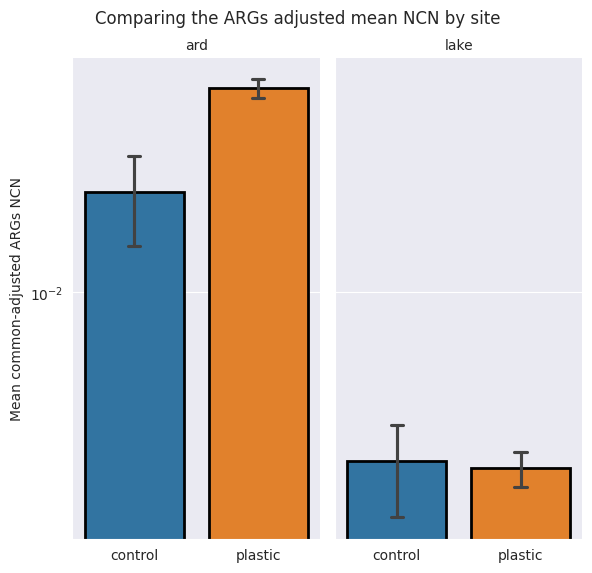

In [79]:
with sns.axes_style("darkgrid"):
    cat = sns.catplot(data = arg_general_sums, kind="bar",
                      x="type_g", y="asn", col="ambient",
                      height=6, aspect=0.5, hue = "type_g",
                      errorbar = "se", capsize = 0.1, ecolor = "black",
                      fill = True,  edgecolor = "black", linewidth = 2 
                    )
    cat.fig.subplots_adjust(top=0.9)
    cat.fig.suptitle('Comparing the ARGs adjusted mean NCN by site')
    cat.set_xlabels("")
    cat.set_ylabels("Mean common-adjusted ARGs NCN")
    cat.set_titles("{col_name}")
    plt.yscale("log")
plt.savefig("Site separated mean of common, adjusted ARG NCN.png", bbox_inches= "tight")

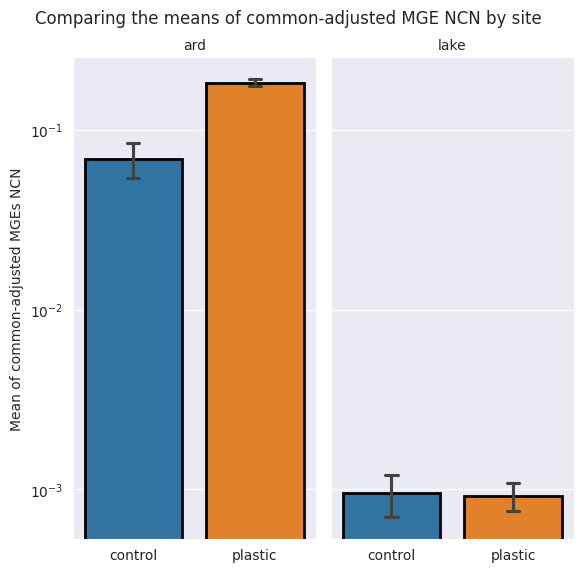

In [80]:
with sns.axes_style("darkgrid"):
    cat = sns.catplot(data = mge_general_sums, kind="bar",
                      x="type_g", y="asn", col="ambient",
                      height=6, aspect=0.5, hue = "type_g",
                      errorbar = "se", capsize = 0.1, ecolor = "black",
                      fill = True,  edgecolor = "black", linewidth = 2 
                    )
    cat.fig.subplots_adjust(top=0.9)
    cat.fig.suptitle('Comparing the means of common-adjusted MGE NCN by site')
    cat.set_xlabels("")
    cat.set_ylabels("Mean of common-adjusted MGEs NCN")
    cat.set_titles("{col_name}")
    plt.yscale("log")
plt.savefig("Site separated Mean of common, adjusted MGEs NCN.png", bbox_inches= "tight")

#### Resultados a nivel de familias de Abs
La idea es repetir los mismos tests que antes (separando siempre por sitio), pero en cada caso quedándonos con sólo una familia de ARGs/MGEs, a ver qué pasa

In [123]:
fixed_all

,Assay,antib,sample,place,type_f,type_g,or_seq,rel_ab,ambient,adjust
4259,aac3-Via,Aminoglycoside,7.0,uru,EPS,plastic,arg,0.009441,lake,10.0
4366,oprD,MDR,7.0,uru,EPS,plastic,arg,0.000264,lake,10.0
4376,mexB,MDR,7.0,uru,EPS,plastic,arg,0.000343,lake,10.0
4377,mdtg,MDR,7.0,uru,EPS,plastic,arg,0.000455,lake,10.0
4501,intI1F165_clinical,Integrase,7.0,uru,EPS,plastic,mge,0.002183,lake,5.0
...,...,...,...,...,...,...,...,...,...,...
3419,tnpAg,Transposase,21.0,ardley,soil,control,mge,0.000647,ard,43.0
3424,dfra21,Trimethoprim,21.0,ardley,soil,control,arg,0.089125,ard,192.0
3427,dfrA10,Trimethoprim,21.0,ardley,soil,control,arg,0.013428,ard,192.0
3433,dfrAB4,Trimethoprim,21.0,ardley,soil,control,arg,0.000095,ard,192.0


In [130]:
%matplotlib agg
os.chdir(ca_dir)
os.chdir("target_results_general")
typeg_dir = os.getcwd()
os.chdir("../target_results_fine")
typef_dir = os.getcwd()
for antib in fixed_all["antib"].unique():
    print("##### Working on ", antib.upper(), " #####")
    antib_data = fixed_all.loc[fixed_all["antib"] == antib]
    for grouping in ["type_g", "type_f"]:
        print (grouping.upper())
        if grouping == "type_g":
            os.chdir(typeg_dir)
        else:
            os.chdir(typef_dir)
        
        
        
        sp_grouped = antib_data.groupby(["place", "sample", "ambient", grouping]) 
        summed_samples = sp_grouped["rel_ab"].sum() # y calcula la suma del nº de copias de todos los integrantes
        summed_samples = summed_samples.reset_index() #aquí paso a df para facilitar el resto de pasos

        for place in summed_samples["place"].unique():
            summed_samples.loc[summed_samples["place"] == place, "adjust"] = int(antib_data.loc[antib_data["place"] == place]["adjust"].unique())

        # Adjust the NCN value. Adjusted Summed NCN = asn
        summed_samples["asn"] = summed_samples["rel_ab"] / summed_samples["adjust"]
        summed_samples["n_log2"] = np.log2(summed_samples["asn"])
        
        for ambient in summed_samples["ambient"].unique():
            print("Working on ", ambient.upper())
            ambient_samples = summed_samples.loc[summed_samples["ambient"] == ambient]
            var_lst = [group["asn"] for name, group in ambient_samples.groupby([grouping])] 
            nam_lst = [name for name, group in ambient_samples.groupby([grouping])] 
            var_lst_ln = [group["n_log2"] for name, group in ambient_samples.groupby([grouping])]
            fname = antib.upper() + "-" + ambient.upper() + "-" + grouping.upper() + "-arg_group_statistics.txt"
            with open(fname, "w") as file:
                print("Regular_values: ", stats.levene(*var_lst), file = file)
                try:
                    print("Regular_kruskal: ", stats.kruskal(*var_lst), file = file)
                    print("Log2_kruskal: ", stats.kruskal(*var_lst_ln), file = file)
                    print("Log2_values: ", stats.levene(*var_lst_ln), file = file)
                except:
                    print("Log2_values: ", stats.levene(*var_lst_ln), file = file)     
        post_lolo = sp.posthoc_conover(var_lst, p_adjust = "fdr_bh")
        post_lolo.rename(columns = {original_num:new_name for (original_num, new_name) in zip(post_lolo.columns, nam_lst)},
                         index = {original_num:new_name for (original_num, new_name) in zip(post_lolo.index, nam_lst)},
                         inplace = True)
        post_lolo = post_lolo[post_lolo < 0.05]
        fname = antib.upper() + "-" + ambient.upper() + "-" + grouping.upper() + "all_arg_comparisions.csv"
        post_lolo.to_csv(fname)

        fname = antib + "--adjusted NCN sums.png"
        plot_title = "Comparing the sum of all " + antib.upper() + " NCNs by site"
    
        with sns.axes_style("darkgrid"):
            cat = sns.catplot(data = summed_samples, kind="bar",
                              x=grouping, y="asn", col="ambient",
                              height=6, aspect=0.5,
                              errorbar = "se", capsize = 0.1, ecolor = "black", hue = grouping,
                              fill = True,  edgecolor = "black", linewidth = 2
                             )
            cat.fig.subplots_adjust(top=0.9)
            cat.fig.suptitle(plot_title)
            cat.set_xlabels("")
            cat.set_ylabels("sum of all NCNs")
            plt.yscale("log")
            cat.set_titles("{col_name}")
            plt.savefig(fname, bbox_inches= "tight")


##### Working on  AMINOGLYCOSIDE  #####
TYPE_G
Working on  ARD
Working on  LAKE
TYPE_F
Working on  ARD
Working on  LAKE
##### Working on  MDR  #####
TYPE_G
Working on  ARD
Working on  LAKE
TYPE_F
Working on  ARD
Working on  LAKE
##### Working on  INTEGRASE  #####
TYPE_G
Working on  ARD
Working on  LAKE
TYPE_F
Working on  ARD
Working on  LAKE
##### Working on  PLASMID  #####
TYPE_G
Working on  ARD
Working on  LAKE
TYPE_F
Working on  ARD
Working on  LAKE
##### Working on  PLASMID-INC  #####
TYPE_G
Working on  ARD
Working on  LAKE
TYPE_F
Working on  ARD
Working on  LAKE
##### Working on  FLUOROQUINOLONE  #####
TYPE_G
Working on  ARD
Working on  LAKE
TYPE_F
Working on  ARD
Working on  LAKE
##### Working on  BETA LACTAM  #####
TYPE_G
Working on  ARD
Working on  LAKE
TYPE_F
Working on  ARD
Working on  LAKE
##### Working on  INSERTIONAL  #####
TYPE_G
Working on  ARD
Working on  LAKE
TYPE_F
Working on  ARD
Working on  LAKE
##### Working on  MLSB  #####
TYPE_G
Working on  ARD
Working on  LAKE
T